# XAI Tutorial of Gianni Franchi Rémi KAZMIERCZAK
**PLEASE write your name and first name here:**

Welcome to your XAI project!
**In this notebook, you will**:
- Learn  about classification
- Learn about XAI
- Learn about CLIP
- Learn what are Concept Bottleneck Models (CBMs)


If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.

## 0 Visualisation of the dataset


In [42]:
# First we download the dataset. In order to have fast download please use this command line
# !pip install gdown

# !gdown 1PdMjITeGZjfSp__87mfpY8mTcMTPsDB0
# !unzip Cats_Dogs_Cars_Reduced.zip

We have constructed a dataset that includes images of black and white dogs, cars, and cats. The dataset consists of three classes: **cats**, **dogs**, and **cars**. To have a better understanding of the DNN biais, we've organized explicit folders for each color within each class. This arrangement allows us to explore whether the Deep Neural Network (DNN) relies solely on color information for classification, enabling us to train and evaluate the model with images of a single multiple colors.

In [43]:
import os

# Path to the dataset root on local machine
dataset_root = "/users/eleves-b/2024/yulong.ma/Colab Notebooks/Cats_Dogs_Cars_Reduced"

if os.path.exists(dataset_root):
    print("Dataset directory found:")
    print(dataset_root)
else:
    print("Dataset directory NOT found!")
    print("Please check the path in this cell or make sure the dataset is extracted correctly.")

Dataset directory found:
/users/eleves-b/2024/yulong.ma/Colab Notebooks/Cats_Dogs_Cars_Reduced


In [44]:
import glob
from PIL import Image
import torch
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F



class Cats_Dogs_dataset_x(torch.utils.data.Dataset):
  # Cats_Dogs_dataset (torch dataset)

  def __init__(self,root,phase,preprocess,device='cuda',set_dogs='Black+White',set_cats='Black+White',
               set_cars='Black+White'):
    super(Cats_Dogs_dataset_x, self).__init__()

    '''
    Cats and dogs dataset + some tools to create usefuls subdatasets
    root: Root of the data (/.../semanticPascalPart)
    phase: Phase of the learning in ['train','val','test']
    shuffle: Shuffle the dataset items
    device: Gpu (or cpu) to use
    save_mode: after precomputing the images, save this as npy files
    '''

    self.preprocess = preprocess
    self.device = device
    self.List_classes = ['Dogs','Cats','Cars']
    self.info_dataset = {'Dogs':set_dogs.split('+'),'Cats':set_cats.split('+'),'Cars':set_cars.split('+')}
    self.img_paths = []
    self.labels = []

    # New version save npy files

    for pet_class in ['Dogs','Cats','Cars']:
      for color in self.info_dataset[pet_class] :
        paths_images_subset = sorted(glob.glob(root+'/'+pet_class+'/'+color+'/*.jpg'))
        imgs_train_subset,imgs_val_subset,imgs_test_subset = self.split_dataset(paths_images_subset)
        if phase == 'train':
          self.img_paths+=imgs_train_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_train_subset))]

        if phase == 'test':
          self.img_paths+=imgs_val_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_val_subset))]

        if phase == 'val':
          self.img_paths+=imgs_test_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_test_subset))]

  def split_dataset(self,img_ids,split_seed=-1):

    if split_seed != -1 :

      np.random.seed(split_seed)
      np.random.shuffle(img_ids)

    l = len(img_ids)

    img_ids_train = img_ids[:int(l * 0.6)]
    img_ids_test = img_ids[int(l * 0.6):int(l * 0.8)]
    img_ids_val = img_ids[int(l * 0.8):]

    return img_ids_train, img_ids_val, img_ids_test

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,index):

    path = self.img_paths[index]
    img = Image.open(path)

    img_tensor= self.preprocess(img)
    img_tensor = img_tensor.to(self.device)

    label = self.labels[index]

    return {'input':img_tensor,'label':label,'path':path}

In [45]:
# all_color = True
# color_white=False #  please play with the color to build biais or not
# root = dataset_root

# if all_color:
#   # generation of the dataloader for the 3 classes with all the color
#   D_set_dogs = {'train':'Black+White','val':'Black+White','test':'Black+White'}
#   D_set_cats = {'train':'Black+White','val':'Black+White','test':'Black+White'}
#   D_set_cars = {'train':'Black+White','val':'Black+White','test':'Black+White'}

#   # root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
#   # root = '/content/Cats_Dogs_Cars_Reduced'

#   weights = ResNet50_Weights.DEFAULT
#   preprocess_resnet = weights.transforms()

#   Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
#   Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
#   Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



#   dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
#   dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
#   dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)
# elif color_white:
#   # generation of the dataloader for the 3 classes with all the color
#   D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
#   D_set_cats = {'train':'White','val':'White','test':'Black+White'}
#   D_set_cars = {'train':'White','val':'White','test':'Black+White'}
#   #D_set_cars = {'train':'','val':'','test':''}

#   root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
#   root = '/content/Cats_Dogs_Cars_Reduced'

#   weights = ResNet50_Weights.DEFAULT
#   preprocess_resnet = weights.transforms()

#   Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
#   Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
#   Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



#   dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
#   dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
#   dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)
# Control which color subsets are used

all_color = True
color_white = False  # switch this later to study bias

# Use the dataset_root defined earlier instead of Colab paths
root = dataset_root

# Define which colors to use for each split and class
if all_color:
    # All colors (Black + White) for all splits
    D_set_dogs = {'train': 'Black+White', 'val': 'Black+White', 'test': 'Black+White'}
    D_set_cats = {'train': 'Black+White', 'val': 'Black+White', 'test': 'Black+White'}
    D_set_cars = {'train': 'Black+White', 'val': 'Black+White', 'test': 'Black+White'}
elif color_white:
    # Only White in train/val, Black+White in test (to create color bias)
    D_set_dogs = {'train': 'White', 'val': 'White', 'test': 'Black+White'}
    D_set_cats = {'train': 'White', 'val': 'White', 'test': 'Black+White'}
    D_set_cars = {'train': 'White', 'val': 'White', 'test': 'Black+White'}
else:
    raise ValueError("Please set either all_color or color_white to True.")

# Load pretrained ResNet-50 weights and corresponding preprocessing
weights = ResNet50_Weights.DEFAULT
preprocess_resnet = weights.transforms()

# Create dataset objects
Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(
    root,
    'train',
    preprocess_resnet,
    set_dogs=D_set_dogs['train'],
    set_cats=D_set_cats['train'],
    set_cars=D_set_cars['train'],
)

Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(
    root,
    'val',
    preprocess_resnet,
    set_dogs=D_set_dogs['val'],
    set_cats=D_set_cats['val'],
    set_cars=D_set_cars['val'],
)

Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(
    root,
    'test',
    preprocess_resnet,
    set_dogs=D_set_dogs['test'],
    set_cats=D_set_cats['test'],
    set_cars=D_set_cars['test'],
)


batch_size = 64 

# Create dataloaders
dataloader_train = torch.utils.data.DataLoader(
    Cats_Dogs_dataset_x_train,
    shuffle=True,
    batch_size=batch_size,
)

dataloader_val = torch.utils.data.DataLoader(
    Cats_Dogs_dataset_x_val,
    shuffle=True,
    batch_size=batch_size,
)

dataloader_test = torch.utils.data.DataLoader(
    Cats_Dogs_dataset_x_test,
    shuffle=False,
    batch_size=batch_size,
)

print("Number of training samples:", len(Cats_Dogs_dataset_x_train))
print("Number of validation samples:", len(Cats_Dogs_dataset_x_val))
print("Number of test samples:", len(Cats_Dogs_dataset_x_test))

Number of training samples: 1950
Number of validation samples: 650
Number of test samples: 655


Batch size: 64
Image tensor shape: torch.Size([64, 3, 224, 224])
Example paths (first 3):
   /users/eleves-b/2024/yulong.ma/Colab Notebooks/Cats_Dogs_Cars_Reduced/Cats/Black/2134.jpg
   /users/eleves-b/2024/yulong.ma/Colab Notebooks/Cats_Dogs_Cars_Reduced/Cats/White/1230.jpg
   /users/eleves-b/2024/yulong.ma/Colab Notebooks/Cats_Dogs_Cars_Reduced/Dogs/White/1226.jpg


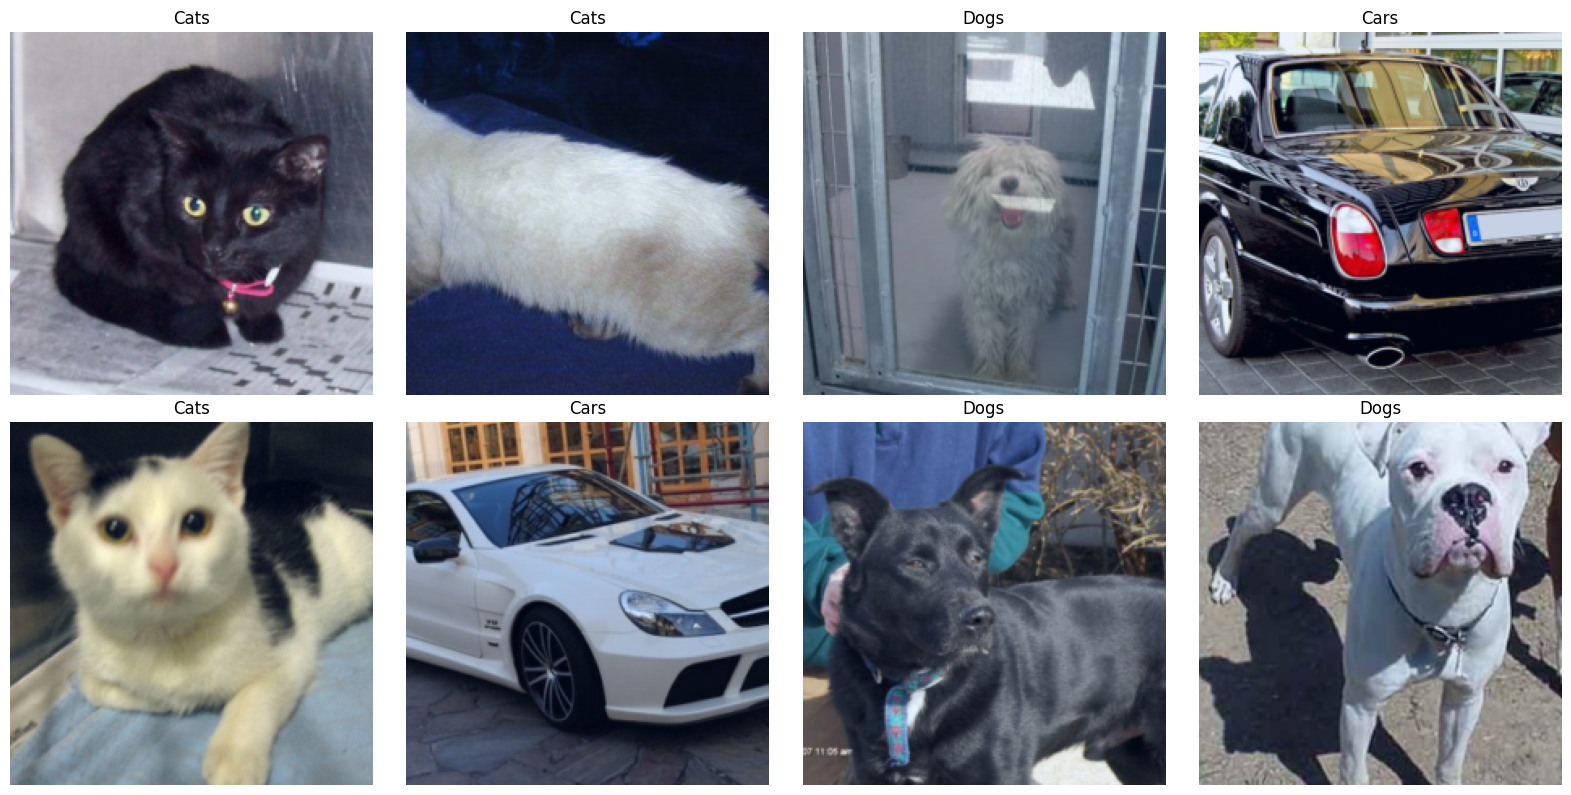

In [46]:
import matplotlib.pyplot as plt

# Mapping from label index to class name
idx_to_class = {0: "Dogs", 1: "Cats", 2: "Cars"}

# Get one batch from the training dataloader
batch = next(iter(dataloader_train))
images = batch["input"]      # shape: (B, C, H, W)
labels = batch["label"]      # shape: (B,)
paths = batch["path"]        # list of file paths

print("Batch size:", images.shape[0])
print("Image tensor shape:", images.shape)
print("Example paths (first 3):")
for p in paths[:3]:
    print("  ", p)

# Number of images to visualize
num_show = 8
num_show = min(num_show, images.shape[0])

plt.figure(figsize=(16, 8))
for i in range(num_show):
    img = images[i].detach().cpu().numpy()  # (C, H, W)
    
    # Simple min-max normalization for visualization
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)
    
    # Convert from (C, H, W) to (H, W, C)
    img = img.transpose(1, 2, 0)
    
    label_idx = int(labels[i].item())
    class_name = idx_to_class[label_idx]
    
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"{class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 1 Classical Supervised Classification with Resnet 50

You work now with Resnet 50, but when we work with CLIP you will work with ViT
**question 0 :  Why we do not use here ViT?**

ViT models usually shine with large-scale data or strong pretraining. For a small dataset like this one, a pretrained ResNet-50 is more stable and easier to train.

CNNs have strong inductive biases for image data (local connectivity, weight sharing), which work well on small to medium datasets.

ResNet-50 is easy to use, stable and fast. Using it as a baseline lets us focus on XAI and CLIP, not on tuning a more fragile architecture.

In [47]:
# Define the model and the optimizer

class resnet50_classif(nn.Module):
	def __init__(self,device, output_dim,Freeze_backbone=True):
		super().__init__()
		self.Freeze_backbone = Freeze_backbone
		resnet50_all = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
		self.resnet50 = torch.nn.Sequential(*(list(resnet50_all.children())[:-1]))
		self.linear = nn.Linear(2048, output_dim)

	def forward(self, x):
		if self.Freeze_backbone :
			with torch.no_grad() :
				x = self.resnet50(x)
		else :
			x = self.resnet50(x)
		x = x.squeeze(-1).squeeze(-1) # ??? Don't know why self.resnet50 return (1,2048,1,1) shape
		x = self.linear(x)
		x = F.softmax(x, dim=1)

		return x


In [48]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data['input'].to(device)
            labels = data['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']

model = resnet50_classif(device,len(List_classes),Freeze_backbone=False)
model.to(device)

'''import torchvision.models as models
# Define your ResNet50 model
model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3).to(device)'''

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    if val_acc > best_score :
      best_epoch = epoch
      best_score = val_acc
      torch.save(model,'best_model_run_resnet50.pth')

# Test the trained model
best_model = torch.load('./best_model_run_resnet50.pth',weights_only=False).to(device)
test_loss, test_acc = evaluate_model(best_model, dataloader_test, criterion,device)
print('Best Epoch',best_epoch)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/31 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]


Epoch [1/10] - Train Loss: 0.7633 - Train Acc: 90.87% - Val Loss: 0.5673 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  5.41it/s]


Epoch [2/10] - Train Loss: 0.5617 - Train Acc: 99.54% - Val Loss: 0.5667 - Val Acc: 98.46%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  5.26it/s]


Epoch [3/10] - Train Loss: 0.5586 - Train Acc: 99.38% - Val Loss: 0.5694 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  5.49it/s]


Epoch [4/10] - Train Loss: 0.5564 - Train Acc: 99.64% - Val Loss: 0.5737 - Val Acc: 97.85%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  4.69it/s]


Epoch [5/10] - Train Loss: 0.5534 - Train Acc: 100.00% - Val Loss: 0.5714 - Val Acc: 98.15%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s]


Epoch [6/10] - Train Loss: 0.5522 - Train Acc: 100.00% - Val Loss: 0.5681 - Val Acc: 98.15%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]


Epoch [7/10] - Train Loss: 0.5519 - Train Acc: 100.00% - Val Loss: 0.5713 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  4.54it/s]


Epoch [8/10] - Train Loss: 0.5517 - Train Acc: 100.00% - Val Loss: 0.5669 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  5.02it/s]


Epoch [9/10] - Train Loss: 0.5520 - Train Acc: 99.95% - Val Loss: 0.5707 - Val Acc: 98.00%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  5.33it/s]


Epoch [10/10] - Train Loss: 0.5519 - Train Acc: 100.00% - Val Loss: 0.5686 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s]

Best Epoch 2
Test Loss: 0.5684 - Test Acc: 98.32%


**Question 1: Try applying [Class Activation Maps](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) (CAMs) to enhance the interpretability of the classification results. (if you prefere you can use GradCam)**

**Question 2: What do you think about the quality of the explanation of your classification.** (hint show cases where the CAM is not good enough)

In [50]:
import numpy as np
from scipy.ndimage import zoom

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        if grad_output[0] is not None:
            self.gradients = grad_output[0].detach().clone()
        else:
            self.gradients = None

    def generate_cam(self, input_image, target_class=None):
        self.model.eval()
        self.gradients = None
        self.activations = None

        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        else:
            target_class = int(target_class) if hasattr(target_class, 'item') else int(target_class)

        self.model.zero_grad()
        output[0, target_class].backward()

        if self.gradients is None:
            raise RuntimeError("Grad-CAM: gradient not captured. Ensure model and input are on the same device.")
        grads = self.gradients
        acts = self.activations.detach()
        gradients = grads[0].cpu().numpy() if grads.dim() == 4 else grads.cpu().numpy()
        activations = acts[0].cpu().numpy() if acts.dim() == 4 else acts.cpu().numpy()
        
        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))
        
        # Weighted combination of activation maps
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        
        # Apply ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        cam = cam / (cam.max() + 1e-8)
        
        return cam, output

In [51]:
def visualize_gradcam(model, dataloader, idx_to_class, num_samples=8, device='cuda'):
    # Get the last convolutional layer from ResNet-50
    target_layer = None
    for name, module in model.resnet50.named_modules():
        if 'layer4' in name and isinstance(module, torch.nn.Conv2d):
            target_layer = module
    
    if target_layer is None:
        # Fallback: find the last Conv2d layer
        for module in reversed(list(model.resnet50.modules())):
            if isinstance(module, torch.nn.Conv2d):
                target_layer = module
                break
    
    if target_layer is None:
        raise ValueError("Could not find a convolutional layer in the model")
    
    grad_cam = GradCAM(model, target_layer)
    
    # Get a batch
    batch = next(iter(dataloader))
    images = batch["input"]
    labels = batch["label"]
    paths = batch["path"]
    
    num_samples = min(num_samples, images.shape[0])
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    # Colormap for heatmap (simulating JET colormap)
    def apply_colormap(cam):
        cam_normalized = (cam * 255).astype(np.uint8)
        # Simple colormap: blue -> cyan -> yellow -> red
        heatmap = np.zeros((*cam.shape, 3), dtype=np.float32)
        heatmap[:, :, 0] = np.clip(4 * (cam_normalized - 128) / 255, 0, 1)  # Red
        heatmap[:, :, 1] = np.clip(1 - 2 * np.abs(cam_normalized - 128) / 255, 0, 1)  # Green
        heatmap[:, :, 2] = np.clip(1 - 4 * (cam_normalized - 64) / 255, 0, 1)  # Blue
        return heatmap
    
    for i in range(num_samples):
        img_tensor = images[i:i+1].to(device)
        label = int(labels[i].item())
        true_class = idx_to_class[label]
        
        # Generate CAM
        cam, output = grad_cam.generate_cam(img_tensor, target_class=label)
        
        # Get prediction
        pred_class_idx = output.argmax(dim=1).item()
        pred_class = idx_to_class[pred_class_idx]
        
        # Prepare original image for visualization
        img_np = img_tensor[0].cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-5)
        
        # Resize CAM to match image size using scipy
        h_orig, w_orig = img_np.shape[:2]
        h_cam, w_cam = cam.shape
        zoom_factor_h = h_orig / h_cam
        zoom_factor_w = w_orig / w_cam
        cam_resized = zoom(cam, (zoom_factor_h, zoom_factor_w), order=1)
        
        # Apply colormap
        heatmap = apply_colormap(cam_resized)
        
        # Overlay
        overlayed = heatmap * 0.4 + img_np * 0.6
        
        # Plot original
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f"True: {true_class}")
        axes[0, i].axis('off')
        
        # Plot CAM
        axes[1, i].imshow(overlayed)
        axes[1, i].set_title(f"Pred: {pred_class}\nGrad-CAM")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

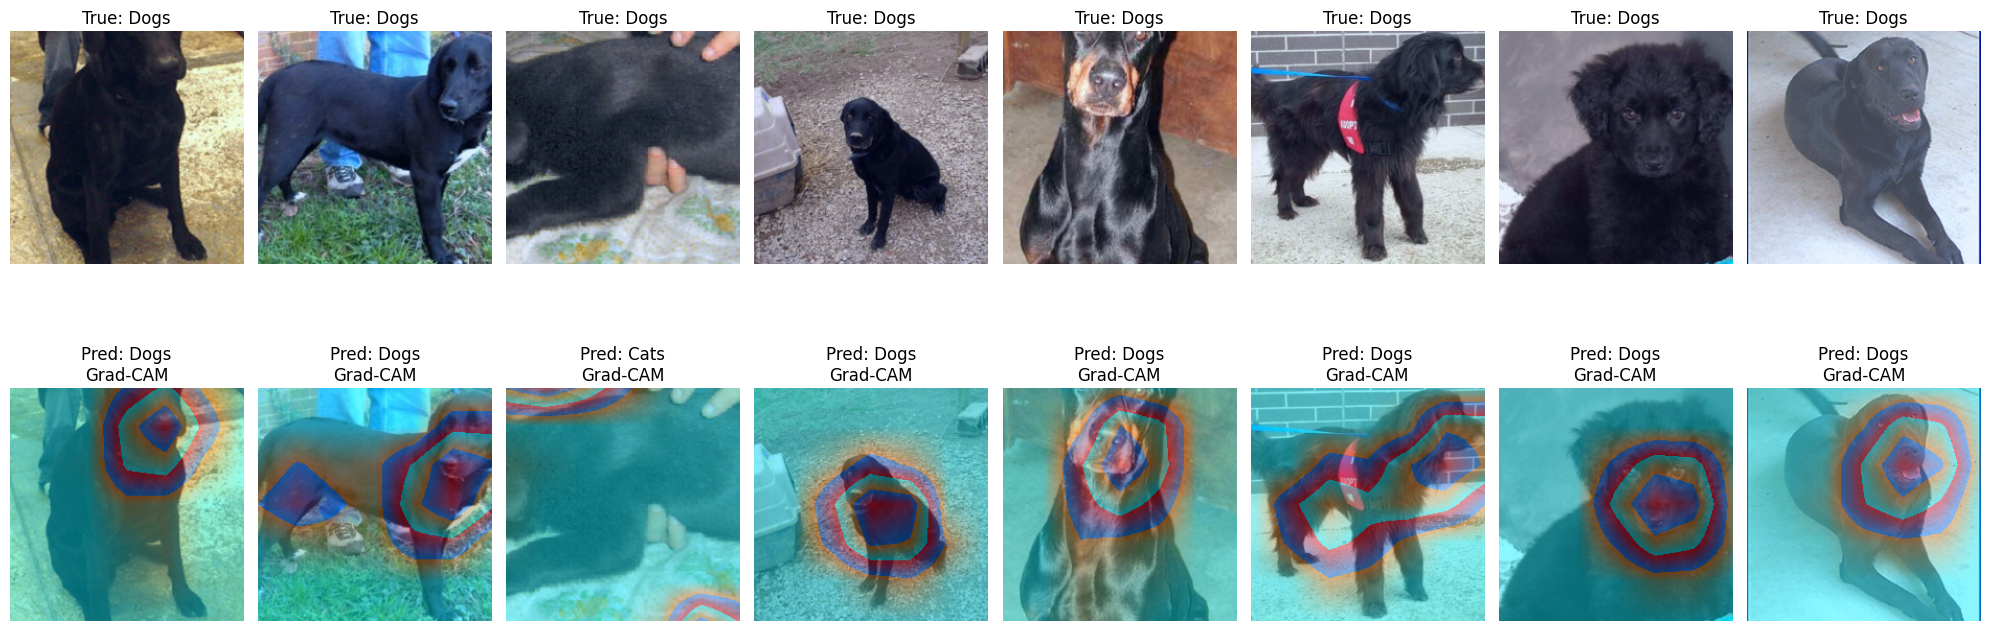

In [52]:
idx_to_class = {0: "Dogs", 1: "Cats", 2: "Cars"}

# Load the best model
best_model = torch.load('./best_model_run_resnet50.pth', weights_only=False).to(device)
best_model.eval()

# Visualize Grad-CAM on test set
visualize_gradcam(best_model, dataloader_test, idx_to_class, num_samples=8, device=device)

In [53]:
def analyze_cam_quality(model, dataloader, idx_to_class, num_samples=20, device='cuda'):
    # Get target layer
    target_layer = None
    for name, module in model.resnet50.named_modules():
        if 'layer4' in name and isinstance(module, torch.nn.Conv2d):
            target_layer = module
    
    if target_layer is None:
        for module in reversed(list(model.resnet50.modules())):
            if isinstance(module, torch.nn.Conv2d):
                target_layer = module
                break
    
    grad_cam = GradCAM(model, target_layer)
    
    # Collect misclassifications and poor CAM cases
    misclassifications = []
    poor_cam_cases = []
    
    all_batches = list(iter(dataloader))
    total_checked = 0
    
    for batch in all_batches:
        images = batch["input"].to(device)
        labels = batch["label"].to(device)
        paths = batch["path"]
        
        for i in range(images.shape[0]):
            if total_checked >= num_samples:
                break
            
            img_tensor = images[i:i+1]
            label = int(labels[i].item())
            true_class = idx_to_class[label]
            
            cam, output = grad_cam.generate_cam(img_tensor, target_class=label)
            pred_class_idx = output.argmax(dim=1).item()
            pred_class = idx_to_class[pred_class_idx]
            
            # Check if misclassified
            if pred_class_idx != label:
                misclassifications.append({
                    'image': img_tensor[0].cpu(),
                    'true_class': true_class,
                    'pred_class': pred_class,
                    'cam': cam,
                    'path': paths[i]
                })
            
            # Check CAM quality: if max activation is too low, it's a poor explanation
            cam_max = cam.max()
            if cam_max < 0.3:  # Threshold for "weak" activation
                poor_cam_cases.append({
                    'image': img_tensor[0].cpu(),
                    'true_class': true_class,
                    'pred_class': pred_class,
                    'cam': cam,
                    'cam_max': cam_max,
                    'path': paths[i]
                })
            
            total_checked += 1
        
        if total_checked >= num_samples:
            break
    
    return misclassifications, poor_cam_cases

# Run analysis
misclassifications, poor_cam_cases = analyze_cam_quality(
    best_model, dataloader_test, idx_to_class, num_samples=100, device=device
)

print(f"Found {len(misclassifications)} misclassifications")
print(f"Found {len(poor_cam_cases)} cases with poor CAM quality (weak activation)")

Found 4 misclassifications
Found 0 cases with poor CAM quality (weak activation)


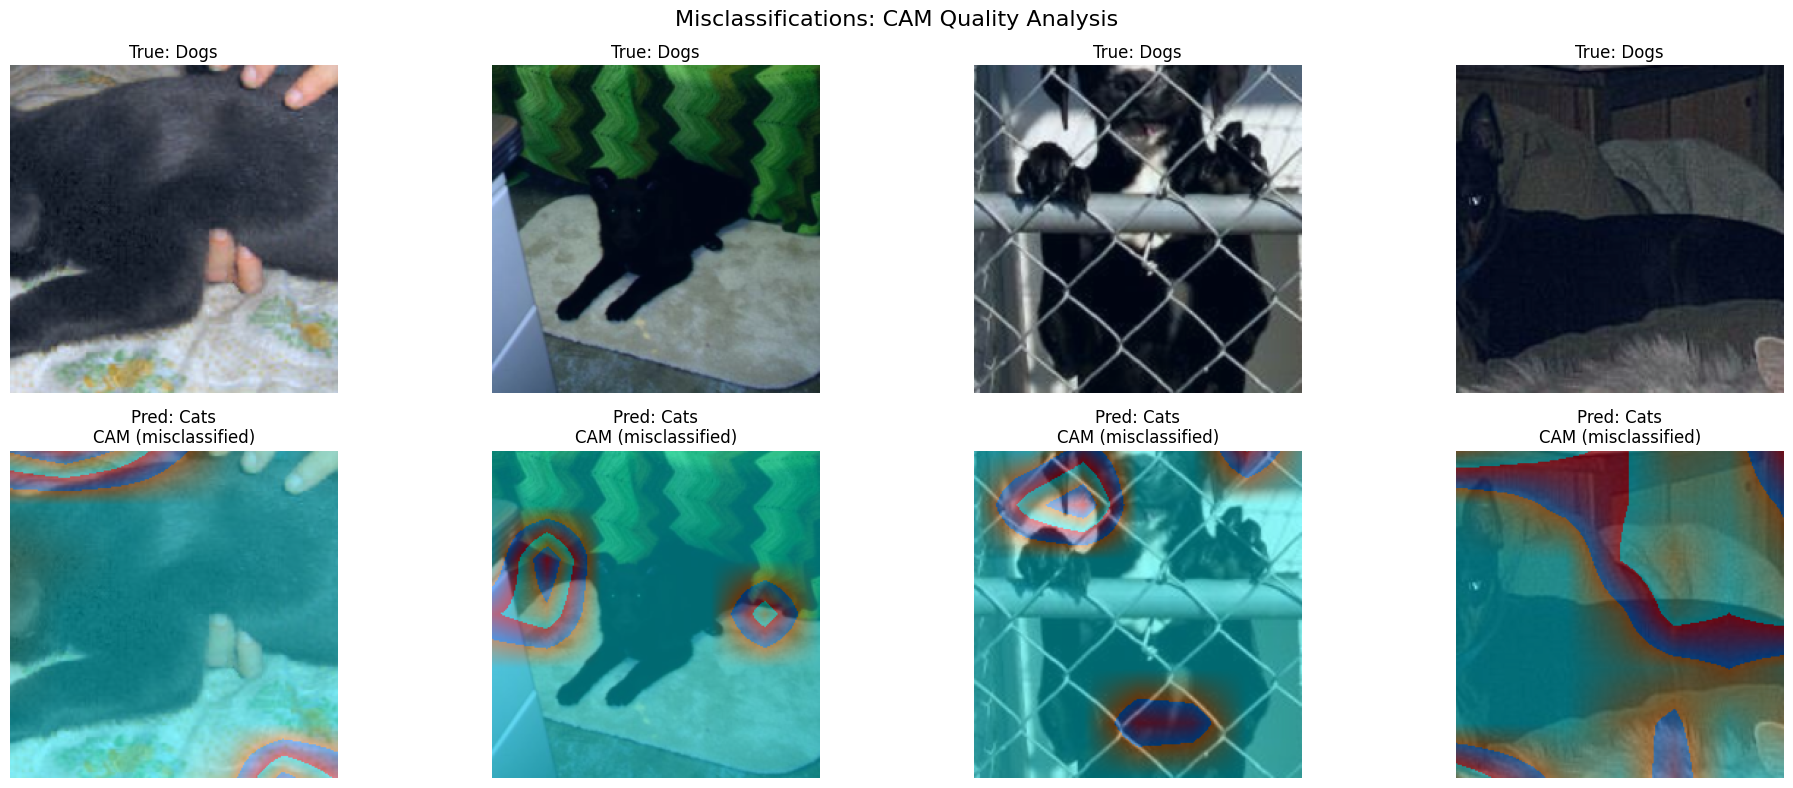

In [54]:
def visualize_poor_cases(misclassifications, poor_cam_cases, idx_to_class, max_show=6):
    from scipy.ndimage import zoom
    
    def apply_colormap(cam):
        cam_normalized = (cam * 255).astype(np.uint8)
        heatmap = np.zeros((*cam.shape, 3), dtype=np.float32)
        heatmap[:, :, 0] = np.clip(4 * (cam_normalized - 128) / 255, 0, 1)
        heatmap[:, :, 1] = np.clip(1 - 2 * np.abs(cam_normalized - 128) / 255, 0, 1)
        heatmap[:, :, 2] = np.clip(1 - 4 * (cam_normalized - 64) / 255, 0, 1)
        return heatmap
    
    # Show misclassifications
    if len(misclassifications) > 0:
        num_show = min(max_show, len(misclassifications))
        fig, axes = plt.subplots(2, num_show, figsize=(20, 8))
        if num_show == 1:
            axes = np.array(axes).reshape(2, 1)
        
        for i in range(num_show):
            case = misclassifications[i]
            img_np = case['image'].numpy().transpose(1, 2, 0)
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-5)
            
            cam = case['cam']
            h_orig, w_orig = img_np.shape[:2]
            h_cam, w_cam = cam.shape
            cam_resized = zoom(cam, (h_orig / h_cam, w_orig / w_cam), order=1)
            heatmap = apply_colormap(cam_resized)
            overlayed = heatmap * 0.4 + img_np * 0.6
            
            axes[0, i].imshow(img_np)
            axes[0, i].set_title(f"True: {case['true_class']}")
            axes[0, i].axis('off')
            
            axes[1, i].imshow(overlayed)
            axes[1, i].set_title(f"Pred: {case['pred_class']}\nCAM (misclassified)")
            axes[1, i].axis('off')
        
        plt.suptitle("Misclassifications: CAM Quality Analysis", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Show poor CAM cases
    if len(poor_cam_cases) > 0:
        num_show = min(max_show, len(poor_cam_cases))
        fig, axes = plt.subplots(2, num_show, figsize=(20, 8))
        if num_show == 1:
            axes = np.array(axes).reshape(2, 1)
        
        for i in range(num_show):
            case = poor_cam_cases[i]
            img_np = case['image'].numpy().transpose(1, 2, 0)
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-5)
            
            cam = case['cam']
            h_orig, w_orig = img_np.shape[:2]
            h_cam, w_cam = cam.shape
            cam_resized = zoom(cam, (h_orig / h_cam, w_orig / w_cam), order=1)
            heatmap = apply_colormap(cam_resized)
            overlayed = heatmap * 0.4 + img_np * 0.6
            
            axes[0, i].imshow(img_np)
            axes[0, i].set_title(f"True: {case['true_class']}")
            axes[0, i].axis('off')
            
            axes[1, i].imshow(overlayed)
            axes[1, i].set_title(f"Pred: {case['pred_class']}\nCAM max: {case['cam_max']:.3f}")
            axes[1, i].axis('off')
        
        plt.suptitle("Poor CAM Quality Cases (Weak Activation)", fontsize=16)
        plt.tight_layout()
        plt.show()

# Visualize
visualize_poor_cases(misclassifications, poor_cam_cases, idx_to_class, max_show=6)

**Q1 — Applying CAM/Grad-CAM for interpretability**

We applied Grad-CAM to our ResNet50 classifier using a convolutional layer from the last block (`layer4`). For an input image, we compute the gradient of a chosen class score with respect to the feature maps of that layer. We average these gradients spatially to get channel weights, combine the activation maps with a weighted sum, apply ReLU, and normalize the result into a 2D heatmap. The heatmap is then resized and overlaid on the image to highlight the regions that most influence the class score.

In our notebook the target class is explicit. In the analysis code we used the ground-truth label as the target, which is useful to inspect class evidence; if the goal is to explain the model’s *actual decision*, targeting the predicted class would be the more direct option.

**Q2 — Quality of the explanations (including failure cases)**

On 100 test images, we found **4 misclassifications** in this run. When the prediction is correct, the heatmap usually concentrates on the main object (dog/cat/car), so the explanation is often easy to interpret.

For misclassified samples the maps are less clear: attention can spread over both the object and the surrounding context, which makes the explanation less informative and hints that texture/background cues may matter in those cases. We also reported **0 “weak activation”** cases, but this check is limited because it uses the CAM maximum after normalization; it mainly detects degenerate near-zero maps. A stronger quality metric would be needed to reliably quantify “bad” explanations.

## 2 : Zeros Shot Classification with CLIP

CLIP (Contrastive Language-Image Pre-training) is a Foundation model developed by OpenAI that has garnered attention for its ability to perform zero-shot classification effectively. Zero-shot classification refers to the capability of a model to recognize and categorize objects or concepts it has never seen during training. CLIP achieves this by bridging the gap between vision and language.

At its core, CLIP is a vision-language model that learns to associate images and their corresponding textual descriptions. Unlike traditional models that rely solely on image data, CLIP is trained on a diverse set of internet images paired with natural language descriptions. This unique training approach allows CLIP to understand the context and relationships between images and their associated textual descriptions.

The key to CLIP's success in zero-shot classification lies in its ability to comprehend textual prompts. During inference, instead of relying solely on visual information, CLIP leverages its knowledge of language to understand the task at hand. This means that users can input textual descriptions or queries to guide CLIP in making predictions about images it has never encountered before.

For example, if CLIP is trained on images of various dog breeds with corresponding textual descriptions, it can successfully classify a new image of a dog even if it has not seen that specific breed during training. By understanding the language associated with images, CLIP generalizes well to novel scenarios, making it a powerful tool for zero-shot classification tasks.


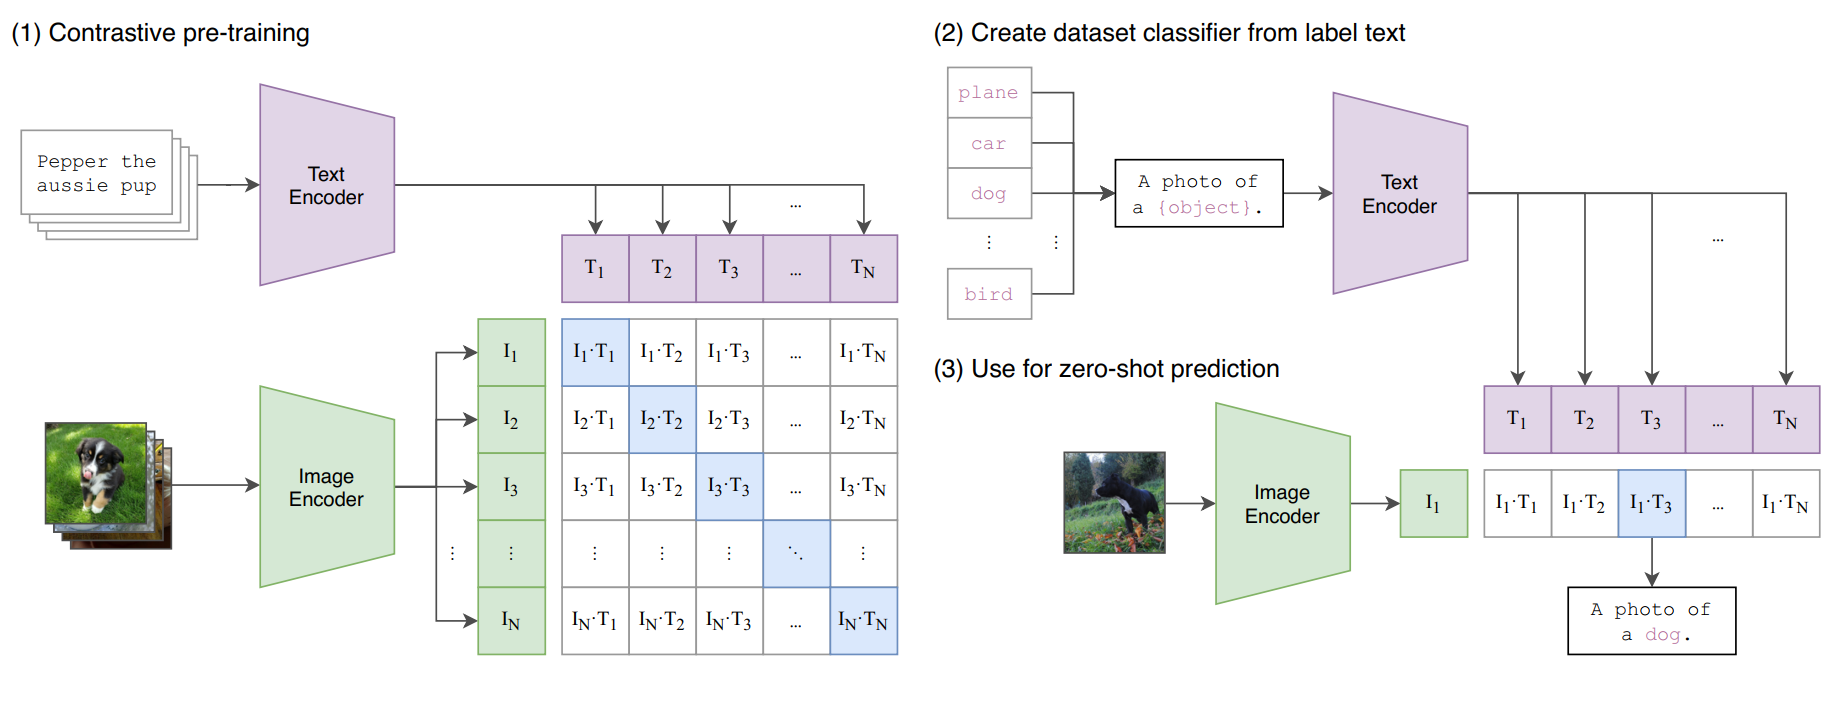

In [55]:
# CLIP: already in conda env .
# #!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

**Question 3: please perform a zeros-shot classification with CLIP on the image just bellow.** We consider that you can choose among three classes cat, dog or car.

In [56]:
import glob
from PIL import Image
import torch
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [57]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)
list_classes = ["a car", "a dog", "a cat"]
path_image = os.path.join(dataset_root, "Dogs/White/9192.jpg")

image = preprocess_clip(Image.open(path_image)).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model_clip.encode_image(image)
    text_tokens = clip.tokenize(list_classes).to(device)
    text_features = model_clip.encode_text(text_tokens)
    logits = (image_features @ text_features.T).float().cpu().numpy()
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
pred_idx = int(np.argmax(probs[0]))
print("Logits:", logits)
print("Probs:", probs)
print("Predicted:", list_classes[pred_idx])

Logits: [[22.703125 26.78125  28.03125 ]]
Probs: [[0.00375818 0.22186317 0.77437866]]
Predicted: a cat


We ran a simple zero-shot classification with CLIP by comparing the image embedding to three text prompts (“a car”, “a dog”, “a cat”) and picking the highest-scoring one. On the example image (`.../Dogs/White/9192.jpg`), CLIP predicts **“a cat”** with high confidence even though the image is a **dog**. So even with a strong pretrained model, zero-shot can still fail on individual samples—typically when the pose/crop is unusual, the object is partially occluded, or the texture/background makes the image look closer to another class.

## 3 : CLIP zero shot

**Question 4: please perform a zeros show classification with CLIP on the test set.** What is your accuracy. What do you think about it.

In [58]:
# Define the evaluation fct
def evaluate_zero_shot_clip(dataloader, model, text):
    n_success = 0
    total = 0
    text_tokens = clip.tokenize(text).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)

    for data in tqdm(dataloader, desc='Evaluating'):
        with torch.no_grad():
            image = data['input'].to(device)
            labels = data['label'].to(device)
            image_features = model.encode_image(image)
            logits = (image_features @ text_features.T).float()
            id_infer = logits.argmax(dim=1).cpu().numpy()
        n_success += (id_infer == labels.cpu().numpy()).sum()
        total += labels.size(0)

    return n_success / total if total > 0 else 0.0

In [59]:


text = ["a dog", "a cat", "a car"]
acc = evaluate_zero_shot_clip(dataloader_test, model_clip, text)
print(f"Zero-shot accuracy on test set: {acc:.4f} ({acc*100:.2f}%)")


Evaluating: 100%|██████████| 11/11 [00:01<00:00,  6.40it/s]

Zero-shot accuracy on test set: 0.9954 (99.54%)


We then evaluated the same zero-shot procedure on the whole test set (using prompts aligned with the three labels). The accuracy is **99.54%**, which is extremely high without any fine-tuning. This suggests CLIP transfers very well to this small 3-class cat/dog/car dataset, and most images are easy enough for the pretrained representation. The remaining mistakes are likely concentrated on a handful of ambiguous cases (hard viewpoints, blur, occlusion, or confusing context). Given this strong baseline, the motivation for the next parts (linear probing / CBM) is less about a big accuracy gain and more about checking whether we can get a cleaner decision rule or better interpretability.

## 4 : Classification avec CLIP + linear probing

Linear probing is commonly employed to evaluate the effectiveness of deep representations once the neural network has undergone sufficient training. This involves training an additional linear classifier on top of the pre-trained features. The parameters of the linear probe are initialized randomly, and the original classifier layer is disregarded. Importantly, the pre-trained backbone remains frozen and undergoes no further training during the linear probing phase.

In [60]:
# Dataset clip_embed
# this function should help you to extract the CLIP embedding
def extract_feature( model, dataloader):
    model.eval()

    batch_idx =0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Extracting'):
            image = data['input'].to(device)
            labels = data['label'].to(device)
            outputs = model.encode_image(image)

            if batch_idx ==0:
              output_concat = outputs.detach().clone()
              target_concat = labels.clone()


            else:
              output_concat=torch.cat((output_concat, outputs.detach()), 0)
              target_concat=torch.cat((target_concat, labels), 0)
            batch_idx+=1


    return  output_concat,target_concat

In [61]:
class Dataset_from_tensor(torch.utils.data.Dataset):

    def __init__(self, data_feature, data_target,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load data as tensor type (Height * Width * Channels)
        if self.phase=='label':
            data_feature = self.data_feature[index].float()
            data_target =  self.data_target[index]
            return {'input':data_feature,'label':data_target}

        else:
            data_feature = self.data_feature[index].float()
            return {'input':data_feature}

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:01<00:00,  5.86it/s]


**Question 5: please perform a linear probing classification with CLIP.**  You need to write the DNN and you need to train it. What is your accuracy. What do you think about it.

In [62]:
# Linear probe: one linear layer on top of CLIP image embedding (512-dim for ViT-B/32)
class linear_probe_img_embed(nn.Module):
    def __init__(self, device, output_dim, model_CLIP="ViT-B/32"):
        super().__init__()
        self.embed_dim = 512  # ViT-B/32 image embedding size
        self.linear = nn.Linear(self.embed_dim, output_dim)

    def forward(self, embed):
        return self.linear(embed)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']
model_CLIP = 'ViT-B/32'

model = linear_probe_img_embed(device,len(List_classes),model_CLIP)
model.to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2241.42it/s]


Epoch [1/10] - Train Loss: 1.0385 - Train Acc: 48.00% - Val Loss: 0.9486 - Val Acc: 64.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2235.44it/s]


Epoch [2/10] - Train Loss: 0.8872 - Train Acc: 74.92% - Val Loss: 0.8147 - Val Acc: 87.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2169.03it/s]


Epoch [3/10] - Train Loss: 0.7637 - Train Acc: 93.59% - Val Loss: 0.7058 - Val Acc: 95.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2243.82it/s]


Epoch [4/10] - Train Loss: 0.6596 - Train Acc: 97.79% - Val Loss: 0.6211 - Val Acc: 97.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2224.88it/s]


Epoch [5/10] - Train Loss: 0.5736 - Train Acc: 98.72% - Val Loss: 0.5372 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2174.85it/s]


Epoch [6/10] - Train Loss: 0.5021 - Train Acc: 99.08% - Val Loss: 0.4703 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2255.99it/s]


Epoch [7/10] - Train Loss: 0.4417 - Train Acc: 99.38% - Val Loss: 0.4151 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2258.42it/s]


Epoch [8/10] - Train Loss: 0.3905 - Train Acc: 99.38% - Val Loss: 0.3700 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2246.66it/s]


Epoch [9/10] - Train Loss: 0.3477 - Train Acc: 99.44% - Val Loss: 0.3355 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2254.34it/s]


Epoch [10/10] - Train Loss: 0.3119 - Train Acc: 99.49% - Val Loss: 0.3097 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2271.32it/s]


Test Loss: 0.2930 - Test Acc: 99.39%


**Q5 — Linear probing with CLIP**

We trained a linear probe on top of frozen CLIP (ViT-B/32) image embeddings. Concretely, we use the 512‑dim CLIP embedding as input and learn a single fully-connected layer that maps it to 3 class logits (Dogs/Cats/Cars). Only the linear layer is trained (cross-entropy loss with Adam), which makes training very fast.

From the training logs, performance increases quickly and stabilizes after a few epochs. After 10 epochs, we obtain **Train Acc ≈ 99.49%**, **Val Acc ≈ 99.08%**, and **Test Acc = 99.39%**.

This is extremely high, which indicates that CLIP embeddings are already almost linearly separable for this dataset. However, the linear probe does **not** improve over the zero-shot CLIP result here (zero-shot was 99.54% in our previous evaluation). So in this setting, learning a classifier on top of CLIP features brings little benefit in accuracy; its main interest is to validate the quality of the representation and to serve as a baseline/stepping stone before introducing the concept bottleneck model (CBM).

## 5 : CLIP concept bottleneck model (CLIP-CBM)


Concept Bottleneck Models are a class of neural network architectures designed to capture and emphasize essential features or concepts within input data. In these models, a bottleneck layer is strategically placed within the network architecture, acting as a compression point that forces the network to distill and retain critical information while discarding less relevant details. The concept bottleneck serves as a conduit for information flow, ensuring that only the most discriminative features relevant to the task at hand pass through. By focusing on the extraction and representation of key concepts, these models aim to enhance interpretability, reduce overfitting, and promote generalization. Concept Bottleneck Models find applications in various domains, including computer vision and natural language processing, where the identification and utilization of high-level concepts are crucial for robust and effective learning.

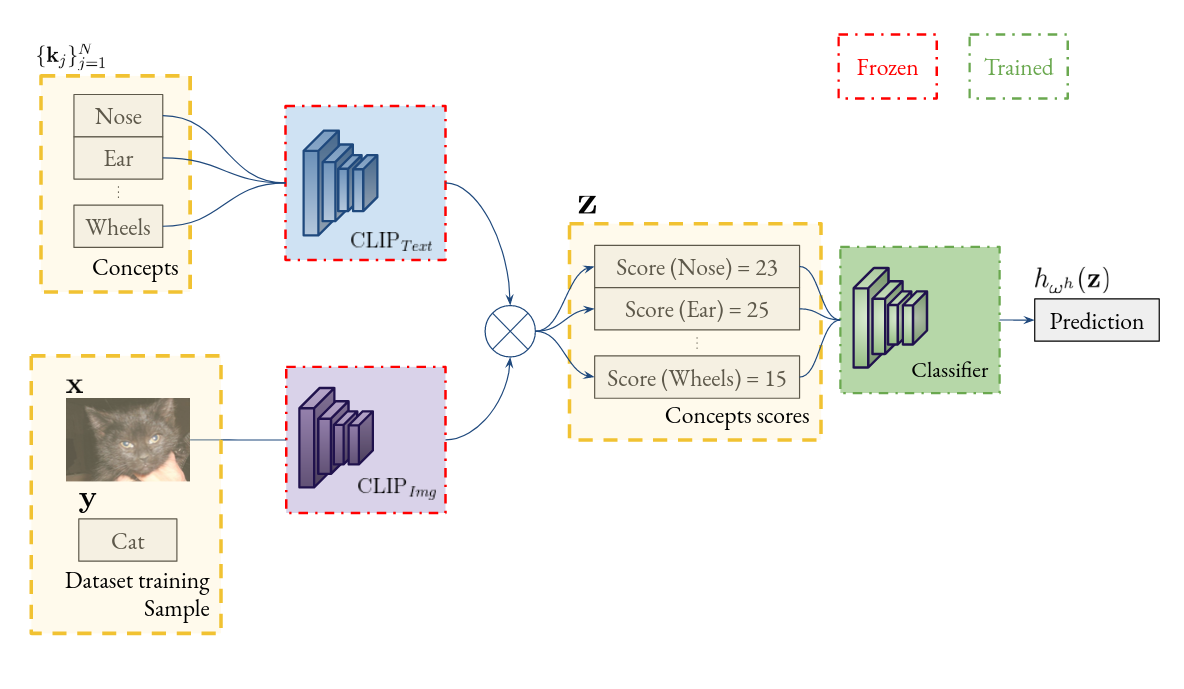

**question6 based on the figure above we want that you extract the a latent space that measure the similarity between the image and a set of concept. Then please write and train a concept bottleneck model.** You need to define the good set of concepts. Analyse your performences with different set of concepts. Compare to your results in question 4.

In [64]:
# Dataset z

List_concepts=['Black','White','Wood','Bottle','Cable']#,'a cat', 'a dog', 'a car'
# you need to write clever concepts
text_featuresconcepts = clip.tokenize(List_concepts).to(device)
text_featuresconcepts = model_clip.encode_text(text_featuresconcepts)

# CBM: image embed -> similarity to each concept (bottleneck) -> linear -> class logits
class CBM_Net(nn.Module):
    def __init__(self, device, output_dim, text_featuresconcepts):
        super().__init__()
        # concept features from CLIP (fixed, not trained); detach to avoid backward graph reuse
        self.register_buffer("concept_features", text_featuresconcepts.float().detach().clone())
        num_concepts = text_featuresconcepts.shape[0]
        self.linear = nn.Linear(num_concepts, output_dim)

    def forward(self, embed):
        # embed: (batch, 512), concept_features: (num_concepts, 512)
        embed_n = F.normalize(embed.float(), dim=1)
        concept_n = F.normalize(self.concept_features, dim=1)
        concept_scores = (embed_n @ concept_n.T).detach()  # (batch, num_concepts); detach so only linear is trained
        return self.linear(concept_scores)




In [65]:
model_unbiaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_unbiaised.to(device)





# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbiaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_unbiaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_unbiaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_unbiaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1950.34it/s]


Epoch [1/10] - Train Loss: 1.0954 - Train Acc: 35.64% - Val Loss: 1.0803 - Val Acc: 46.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1962.79it/s]


Epoch [2/10] - Train Loss: 1.0701 - Train Acc: 42.05% - Val Loss: 1.0460 - Val Acc: 48.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2008.33it/s]


Epoch [3/10] - Train Loss: 1.0335 - Train Acc: 45.95% - Val Loss: 1.0392 - Val Acc: 41.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1960.62it/s]


Epoch [4/10] - Train Loss: 1.0110 - Train Acc: 52.00% - Val Loss: 0.9999 - Val Acc: 64.31%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1973.96it/s]


Epoch [5/10] - Train Loss: 0.9916 - Train Acc: 56.56% - Val Loss: 0.9837 - Val Acc: 46.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1861.80it/s]


Epoch [6/10] - Train Loss: 0.9724 - Train Acc: 55.74% - Val Loss: 0.9680 - Val Acc: 59.85%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2005.01it/s]


Epoch [7/10] - Train Loss: 0.9561 - Train Acc: 56.72% - Val Loss: 0.9349 - Val Acc: 68.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2002.92it/s]


Epoch [8/10] - Train Loss: 0.9375 - Train Acc: 60.92% - Val Loss: 0.9536 - Val Acc: 56.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 2010.43it/s]


Epoch [9/10] - Train Loss: 0.9321 - Train Acc: 57.69% - Val Loss: 0.9260 - Val Acc: 57.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1993.23it/s]


Epoch [10/10] - Train Loss: 0.9203 - Train Acc: 64.00% - Val Loss: 0.8991 - Val Acc: 65.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1984.15it/s]

Test Loss: 0.8806 - Test Acc: 68.40%


In [66]:
# CBM with class-aligned concepts 
List_concepts_class = ["a cat", "a dog", "a car"]
text_featuresconcepts_class = clip.tokenize(List_concepts_class).to(device)
with torch.no_grad():
    text_featuresconcepts_class = model_clip.encode_text(text_featuresconcepts_class)

model_cbm_class = CBM_Net(device, len(List_classes), text_featuresconcepts_class)
model_cbm_class.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cbm_class.parameters(), lr=0.2)
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_cbm_class, dataloader_embed_train, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model_cbm_class, dataloader_embed_val, criterion, device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

test_loss, test_acc = evaluate_model(model_cbm_class, dataloader_embed_test, criterion, device)
print(f"[Concepts: a cat, a dog, a car] Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1933.51it/s]


Epoch [1/10] - Train Loss: 0.9741 - Train Acc: 61.33% - Val Loss: 0.8617 - Val Acc: 55.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1972.36it/s]


Epoch [2/10] - Train Loss: 0.7660 - Train Acc: 92.46% - Val Loss: 0.6713 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1961.87it/s]


Epoch [3/10] - Train Loss: 0.6097 - Train Acc: 99.03% - Val Loss: 0.5416 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1974.72it/s]


Epoch [4/10] - Train Loss: 0.4933 - Train Acc: 99.28% - Val Loss: 0.4425 - Val Acc: 99.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1970.25it/s]


Epoch [5/10] - Train Loss: 0.4082 - Train Acc: 99.38% - Val Loss: 0.3755 - Val Acc: 99.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1968.82it/s]


Epoch [6/10] - Train Loss: 0.3421 - Train Acc: 99.49% - Val Loss: 0.3135 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1964.88it/s]


Epoch [7/10] - Train Loss: 0.2971 - Train Acc: 99.23% - Val Loss: 0.2882 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1980.91it/s]


Epoch [8/10] - Train Loss: 0.2532 - Train Acc: 99.33% - Val Loss: 0.2379 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1992.20it/s]


Epoch [9/10] - Train Loss: 0.2202 - Train Acc: 99.38% - Val Loss: 0.2079 - Val Acc: 99.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 966.98it/s]


Epoch [10/10] - Train Loss: 0.1950 - Train Acc: 99.54% - Val Loss: 0.1872 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1479.47it/s]

[Concepts: a cat, a dog, a car] Test Loss: 0.1819 - Test Acc: 99.39%


**Q6 — Concept Bottleneck Model (CBM) with CLIP concept similarity space**

We built a CBM on top of CLIP image embeddings by introducing an explicit concept bottleneck. For each image embedding (512‑dim, ViT‑B/32), we compute a latent concept vector \(z\) where each entry is the cosine similarity between the image embedding and a concept text embedding (from CLIP). This \(z\) is the “concept similarity space”. A linear layer is then trained on top of \(z\) to predict the 3 classes.

We tested two concept sets:

- **Generic concepts**: [Black, White, Wood, Bottle, Cable].  
  With these concepts, test accuracy is **68.40%**. These concepts are not well aligned with the cat/dog/car decision, so the bottleneck discards relevant information and the classifier is limited.

- **Class-aligned concepts**: [a cat, a dog, a car].  
  With these concepts, test accuracy reaches **99.39%**. Here the bottleneck is directly related to the classes, so the model can largely decide based on which class concept has the highest similarity.

**Comparison to Q4:** zero-shot CLIP achieves **99.54%** on the test set. The CBM with class-aligned concepts is essentially on par (slightly lower in our run), while the CBM with unrelated concepts drops sharply. This highlights that CBMs are only as good as the concept set: task-relevant concepts give an interpretable and effective bottleneck, whereas poorly chosen concepts hurt performance.

**question7: normaly on the previous question you have trained with non biaised a dataset. Please add biaised with the color. For exemple all the object of one class have a color and retrain.** Analyse the results and explain it. Why did we do this experiment.

In [67]:
## train with the biaised dataset
# Biased setup: train/val only White, test Black+White (to measure shortcut learning)
root = dataset_root
D_set_bias = {'train': 'White', 'val': 'White', 'test': 'Black+White'}
Cats_Dogs_train_bias = Cats_Dogs_dataset_x(root, 'train', preprocess_resnet, set_dogs=D_set_bias['train'], set_cats=D_set_bias['train'], set_cars=D_set_bias['train'])
Cats_Dogs_val_bias = Cats_Dogs_dataset_x(root, 'val', preprocess_resnet, set_dogs=D_set_bias['val'], set_cats=D_set_bias['val'], set_cars=D_set_bias['val'])
Cats_Dogs_test_bias = Cats_Dogs_dataset_x(root, 'test', preprocess_resnet, set_dogs=D_set_bias['test'], set_cats=D_set_bias['test'], set_cars=D_set_bias['test'])

dataloader_train_bias = torch.utils.data.DataLoader(Cats_Dogs_train_bias, shuffle=True, batch_size=64)
dataloader_val_bias = torch.utils.data.DataLoader(Cats_Dogs_val_bias, shuffle=True, batch_size=64)
dataloader_test_unbiased = torch.utils.data.DataLoader(Cats_Dogs_dataset_x(root, 'test', preprocess_resnet, set_dogs='Black+White', set_cats='Black+White', set_cars='Black+White'), shuffle=False, batch_size=64)

Clip_embeding_train_bias, target_train_bias = extract_feature(model_clip, dataloader_train_bias)
Clip_embeding_val_bias, target_val_bias = extract_feature(model_clip, dataloader_val_bias)
Clip_embeding_test_unbiased, target_test_unbiased = extract_feature(model_clip, dataloader_test_unbiased)

dataloader_embed_train_bias = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train_bias, target_train_bias), shuffle=True, batch_size=64)
dataloader_embed_val_bias = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val_bias, target_val_bias), shuffle=True, batch_size=64)
dataloader_embed_test_unbiased = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test_unbiased, target_test_unbiased), shuffle=False, batch_size=64)
print("Biased train/val (White only) and unbiased test (Black+White) embed loaders ready.")


Extracting:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting: 100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

Biased train/val (White only) and unbiased test (Black+White) embed loaders ready.


In [68]:
model_biaised = CBM_Net(device, len(List_classes), text_featuresconcepts)
model_biaised.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_biaised.parameters(), lr=0.2)
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_biaised, dataloader_embed_train_bias, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model_biaised, dataloader_embed_val_bias, criterion, device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test on unbiased test set (Black+White) to see if model relied on color shortcut
test_loss, test_acc = evaluate_model(model_biaised, dataloader_embed_test_unbiased, criterion, device)
print(f"[Biased CBM] Test on unbiased set - Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1880.85it/s]


Epoch [1/10] - Train Loss: 1.1067 - Train Acc: 34.86% - Val Loss: 1.1117 - Val Acc: 35.50%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1993.22it/s]


Epoch [2/10] - Train Loss: 1.0785 - Train Acc: 38.20% - Val Loss: 1.0936 - Val Acc: 42.00%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1946.44it/s]


Epoch [3/10] - Train Loss: 1.0673 - Train Acc: 41.45% - Val Loss: 1.0524 - Val Acc: 36.50%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1936.56it/s]


Epoch [4/10] - Train Loss: 1.0420 - Train Acc: 47.04% - Val Loss: 1.0305 - Val Acc: 47.25%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1904.52it/s]


Epoch [5/10] - Train Loss: 1.0325 - Train Acc: 51.29% - Val Loss: 1.0266 - Val Acc: 57.25%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 2005.06it/s]


Epoch [6/10] - Train Loss: 1.0139 - Train Acc: 52.96% - Val Loss: 1.0206 - Val Acc: 59.25%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1958.39it/s]


Epoch [7/10] - Train Loss: 1.0075 - Train Acc: 56.46% - Val Loss: 0.9936 - Val Acc: 65.50%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1979.25it/s]


Epoch [8/10] - Train Loss: 0.9838 - Train Acc: 54.88% - Val Loss: 0.9833 - Val Acc: 42.00%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1967.84it/s]


Epoch [9/10] - Train Loss: 0.9700 - Train Acc: 60.80% - Val Loss: 0.9674 - Val Acc: 58.75%


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1990.11it/s]


Epoch [10/10] - Train Loss: 0.9630 - Train Acc: 58.38% - Val Loss: 0.9519 - Val Acc: 60.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 1996.51it/s]

[Biased CBM] Test on unbiased set - Loss: 0.9626 - Test Acc: 56.79%


**Q7 — Training with a color-biased dataset**

To introduce a color bias, we retrained the CBM on a biased split where **train and validation contain only White images** for all three classes, while the test set is **unbiased** and contains **Black+White** images. The CBM architecture is unchanged: CLIP embeddings are mapped to concept similarities (the bottleneck), and only the final linear layer is trained.

**Results.**  
When evaluated on the unbiased test set, the biased CBM reaches **56.79%** accuracy, which is far below the ~99% level obtained when training on an unbiased dataset (Q6 with class-aligned concepts) and also below the Q4 zero-shot CLIP baseline.

**Interpretation.**  
This performance drop indicates a clear generalization issue under distribution shift: the model has only seen White objects during training, so it does not learn features that are robust to the appearance changes associated with color (or correlated cues that change with color). As a result, when Black examples appear at test time, the decision boundary learned from the biased data does not transfer well.

**Why this experiment?**  
The point is to demonstrate how dataset bias can lead to unreliable models: good performance on a biased training/validation distribution does not guarantee good performance in a more realistic (unbiased) setting. Testing on an unbiased split is therefore important to reveal shortcut learning or lack of robustness, especially when we want explanations and concepts that remain meaningful after deployment.

**question8: please show the statistic of each concept on the latent space of for one class using a CBM** Analyse the results and explain it.




In [69]:
# Statistics of each concept on the latent space for one class (CBM)
def get_concept_scores(model, embed):
    """Return concept scores (batch, num_concepts) from CBM without final linear."""
    embed_n = F.normalize(embed.float(), dim=1)
    concept_n = F.normalize(model.concept_features, dim=1)
    return (embed_n @ concept_n.T).cpu().numpy()

def concept_stats_for_class(model, dataloader_embed, target_class_idx, concept_names, idx_to_class, device):
    """Collect concept scores for all test samples of one class; return (scores array, class name)."""
    all_scores, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader_embed:
            emb = batch["input"].to(device)
            lab = batch["label"]
            sc = get_concept_scores(model, emb)
            all_scores.append(sc)
            all_labels.append(lab.cpu().numpy())
    all_scores = np.concatenate(all_scores, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    mask = all_labels == target_class_idx
    scores_class = all_scores[mask]  # (n_samples_class, num_concepts)
    return scores_class, idx_to_class[target_class_idx]

# Use CBM with class concepts if available, else unbiased CBM with first concept set
cbm_model = model_cbm_class if 'model_cbm_class' in dir() else model_unbiaised
cbm_concepts = List_concepts_class if 'List_concepts_class' in dir() else List_concepts

target_class_idx = 0  # 0=Dogs, 1=Cats, 2=Cars
scores_class, class_name = concept_stats_for_class(
    cbm_model, dataloader_embed_test, target_class_idx,
    cbm_concepts, idx_to_class, device
)
print(f"Class: {class_name}, number of test samples: {scores_class.shape[0]}")
print("Concept statistics (mean +/- std) on latent space:")
for j, cname in enumerate(cbm_concepts):
    m, s = scores_class[:, j].mean(), scores_class[:, j].std()
    print(f"  {cname}: {m:.4f} +/- {s:.4f}")

Class: Dogs, number of test samples: 247
Concept statistics (mean +/- std) on latent space:
  a cat: 0.1968 +/- 0.0168
  a dog: 0.2433 +/- 0.0129
  a car: 0.1774 +/- 0.0115


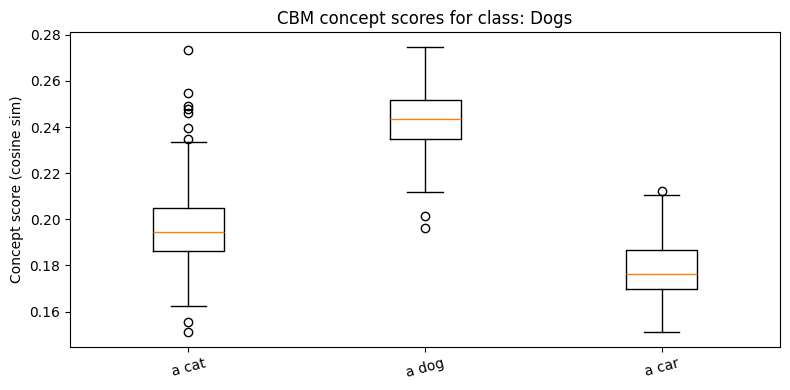

In [70]:
# Visualize: boxplot of concept scores for this class
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot([scores_class[:, j] for j in range(scores_class.shape[1])], tick_labels=cbm_concepts)
ax.set_ylabel("Concept score (cosine sim)")
ax.set_title(f"CBM concept scores for class: {class_name}")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [71]:
# Compare concept statistics across all classes (table + plot)
def collect_all_concept_scores(model, dataloader_embed, concept_names, idx_to_class, device):
    """Collect (scores, labels) for all test samples."""
    all_scores, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader_embed:
            emb = batch["input"].to(device)
            lab = batch["label"].cpu().numpy()
            sc = get_concept_scores(model, emb)
            all_scores.append(sc)
            all_labels.append(lab)
    scores = np.concatenate(all_scores, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return scores, labels

scores_all, labels_all = collect_all_concept_scores(cbm_model, dataloader_embed_test, cbm_concepts, idx_to_class, device)
# Build DataFrame like original notebook (one row per sample, columns = concepts + Class)
import pandas as pd
df = pd.DataFrame(scores_all, columns=cbm_concepts)
df["Class"] = [idx_to_class[i] for i in labels_all]
print("Concept scores per sample (first rows):")
print(df.head())
print(f"\n[{len(df)} rows x {len(df.columns)} columns]")
print("\nMean per class and concept:")
print(df.groupby("Class")[cbm_concepts].mean())

Concept scores per sample (first rows):
      a cat     a dog     a car Class
0  0.199450  0.252804  0.183427  Dogs
1  0.175931  0.220525  0.152502  Dogs
2  0.273348  0.234004  0.198122  Dogs
3  0.200212  0.256509  0.194024  Dogs
4  0.177899  0.237934  0.169788  Dogs

[655 rows x 4 columns]

Mean per class and concept:
          a cat     a dog     a car
Class                              
Cars   0.175446  0.179046  0.241226
Cats   0.249127  0.202400  0.182793
Dogs   0.196787  0.243321  0.177450


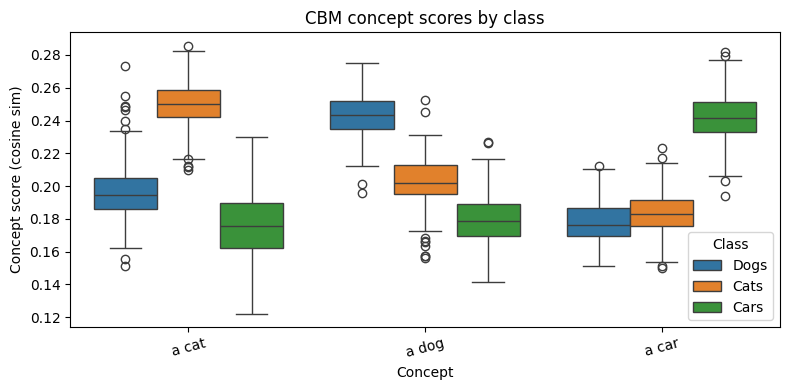

In [72]:
# Visualize: concept scores by class (all classes in one figure)
df_long = df.melt(id_vars=["Class"], value_vars=cbm_concepts, var_name="Concept", value_name="Score")
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_long, x="Concept", y="Score", hue="Class", ax=ax)
ax.set_ylabel("Concept score (cosine sim)")
ax.set_title("CBM concept scores by class")
plt.xticks(rotation=15)
plt.legend(title="Class")
plt.tight_layout()
plt.show()

**Q8 — Statistics of concept scores in the CBM latent space**

We used the trained CBM with the three class concepts (*“a cat”, “a dog”, “a car”*) and computed, for each test image, the **concept scores** in the bottleneck \(z\). Each score is the cosine similarity between the CLIP image embedding and a concept text embedding, so these values are not probabilities but similarity measurements.

**What we did**
- For **one class** (Dogs), we collected the concept scores for all test samples of that class (247 images), reported mean ± std for each concept, and plotted a boxplot.
- We also computed concept-score statistics **for all classes** (655 test images): a per-sample table, class-wise means, and a grouped boxplot (concept on x-axis, score on y-axis, color = class).

**Results**
For Dogs, the matching concept is clearly the highest on average:
- *a dog*: **0.2433 ± 0.0129**
- *a cat*: 0.1968 ± 0.0168
- *a car*: 0.1774 ± 0.0115

Across all classes, the mean scores follow the expected “diagonal” pattern:
- Cars have the highest mean on *a car* (≈ **0.241**),
- Cats on *a cat* (≈ **0.249**),
- Dogs on *a dog* (≈ **0.243**).

**Analysis**
The boxplots show that each class tends to score highest on its corresponding concept, which makes the bottleneck space easy to interpret: the final classifier can rely on these concept similarities to separate the classes. At the same time, the non-matching concepts are not zero and the distributions overlap (e.g., Cats still have non-trivial “a dog” scores around 0.20), which explains why some samples can be ambiguous. Overall, this confirms that with class-aligned concepts, the CBM latent space is both meaningful and aligned with the task.

## 6 : Méthodes d'explications Post-Hoc (LIME et SHAP)

**question9: please try to see  what explain could LIME provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for LIME :   https://github.com/marcotcr/lime


**What we did.**  
We used LIME in two complementary ways when a CBM is available:

1. **Image space (CBM pipeline):** we ran `LimeImageExplainer` on the full prediction pipeline  
   *(image → preprocessing → CLIP image encoder → CBM → class probabilities)*.  
   LIME perturbs superpixels, queries the model, and returns which regions locally support or oppose the predicted class.

2. **Concept space (CBM bottleneck):** we computed the CBM bottleneck features for one test image, i.e. the **concept scores** (cosine similarities) for the concepts *“a cat”, “a dog”, “a car”*.  
   Then we used `LimeTabularExplainer` to explain the **linear head** of the CBM *(concept scores → logits → softmax)*. This produces a bar chart showing which concept ranges contribute positively or negatively to the chosen class.

To compare with a model **without** a CBM, we also applied `LimeImageExplainer` directly to the standard ResNet classifier (no concept bottleneck).

**Results and interpretation (based on the shown example).**  
For the test image `/Cats_Dogs_Cars_Reduced/Dogs/Black/7666.jpg`, the model predicts **Dogs** (true label: Dogs).  
- The **concept-space** explanation is very clear: the rule *“a dog > 0.25”* provides the strongest positive support for the Dogs class. In contrast, the *“a car”* score in the shown interval contributes negatively, while the *“a cat”* interval gives a small positive contribution. Overall, the decision is dominated by the “a dog” concept, which makes the CBM’s reasoning easy to verbalize at the bottleneck level.
- In **image space**, both LIME segment maps indicate which regions the model relies on locally. In this example, the CBM highlights large parts of the dog, but it also highlights an additional background patch, suggesting that either (i) some background texture is used as a secondary cue, or (ii) the local linear approximation introduces some noise. The ResNet (no CBM) highlights a large region near the top/background area, which may indicate reliance on contextual cues rather than the object itself.

**Conclusion.**  
With a CBM, LIME provides both **where** the evidence is in the image (superpixels) and **which concepts** drive the decision (bottleneck-level explanation). Without a CBM, we can still get image-space LIME explanations (e.g. for ResNet), but we lose the direct concept-level explanation because there is no interpretable concept bottleneck to attribute to.

In [1]:
!pip install lime
!pip install shap
!pip install seaborn

Sample path: /users/eleves-b/2024/yulong.ma/Colab Notebooks/Cats_Dogs_Cars_Reduced/Dogs/Black/7666.jpg, true class: Dogs


100%|██████████| 500/500 [00:01<00:00, 472.61it/s]


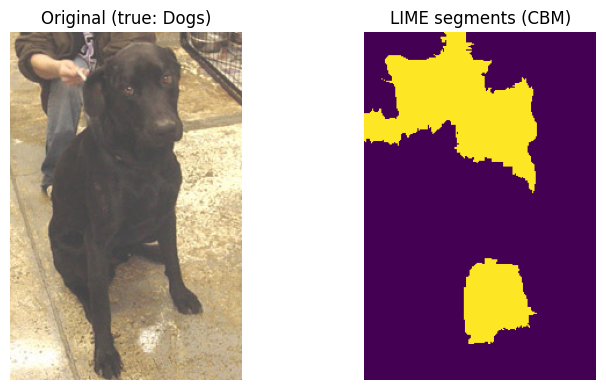

Prediction: Dogs


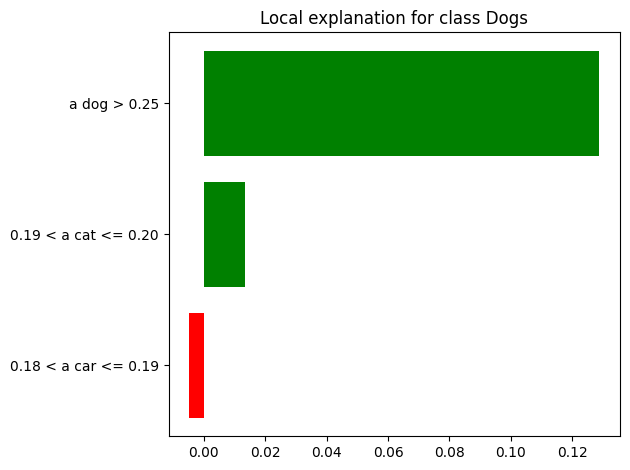

100%|██████████| 500/500 [00:01<00:00, 344.44it/s]


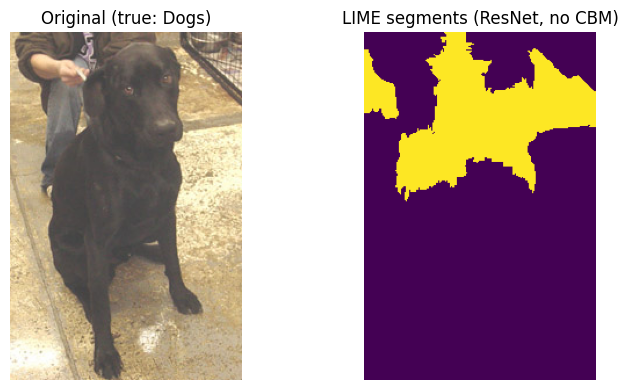

In [74]:
# Uses the full pipeline: image -> (same preprocess as for CLIP embeddings) -> CLIP encode -> CBM -> class.
from lime import lime_image
from PIL import Image
import numpy as np

# CBM and CLIP are from earlier sections; use the same preprocess as when extracting embeddings (ResNet transforms).
cbm_for_lime = model_cbm_class if 'model_cbm_class' in dir() else model_unbiaised

def predict_fn_cbm(images_batch):
    """Predict class probabilities for a batch of numpy images (H,W,3) in [0,1] or [0,255]. Pipeline: preprocess -> CLIP encode -> CBM."""
    cbm_for_lime.eval()
    tensor_list = []
    for img in images_batch:
        if img.max() <= 1.0:
            img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        pil = Image.fromarray(img)
        t = preprocess_resnet(pil).unsqueeze(0)
        tensor_list.append(t)
    x = torch.cat(tensor_list, dim=0).to(device)
    with torch.no_grad():
        emb = model_clip.encode_image(x)
        logits = cbm_for_lime(emb)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

# Get one test image as numpy (from dataset path) for explanation.
batch_test = next(iter(dataloader_test))
sample_path = batch_test["path"][0]
img_pil = Image.open(sample_path).convert("RGB")
image_np = np.array(img_pil)
true_label = batch_test["label"][0].item()
print(f"Sample path: {sample_path}, true class: {idx_to_class[true_label]}")

explainer_lime = lime_image.LimeImageExplainer()
explanation_cbm = explainer_lime.explain_instance(
    image_np,
    predict_fn_cbm,
    labels=list(range(len(List_classes))),
    hide_color=0,
    num_samples=500,
    batch_size=32,
)

# Visualize: show which segments support (green) or oppose (red) the predicted class.
temp, mask = explanation_cbm.get_image_and_mask(
    explanation_cbm.top_labels[0],
    positive_only=False,
    num_features=6,
    hide_rest=False,
)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title(f"Original (true: {idx_to_class[true_label]})")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("LIME segments (CBM)")
plt.axis("off")
plt.tight_layout()
plt.show()

# LIME in concept space (CBM): which concept scores drive the prediction? Produces "Local explanation for class X" bar chart.
concept_names = cbm_concepts if 'cbm_concepts' in dir() else (List_concepts_class if 'List_concepts_class' in dir() else List_concepts)
# Get test image embedding and concept scores (bottleneck).
with torch.no_grad():
    x_one = preprocess_resnet(Image.fromarray(image_np)).unsqueeze(0).to(device)
    test_embed = model_clip.encode_image(x_one)
    embed_n = F.normalize(test_embed.float(), dim=1)
    concept_n = F.normalize(cbm_for_lime.concept_features, dim=1)
    concept_scores_one = (embed_n @ concept_n.T).cpu().numpy().flatten()
pred_class = cbm_for_lime(test_embed).argmax(dim=1).item()
print(f"Prediction: {idx_to_class[pred_class]}")

# Background concept scores from test set (for LIME tabular).
background_concept_scores = []
for batch in dataloader_embed_test:
    emb = batch["input"].to(device)
    with torch.no_grad():
        en = F.normalize(emb.float(), dim=1)
        cn = F.normalize(cbm_for_lime.concept_features, dim=1)
        background_concept_scores.append((en @ cn.T).cpu().numpy())
    if len(background_concept_scores) * emb.shape[0] >= 200:
        break
background_concept_scores = np.vstack(background_concept_scores)[:200]

def predict_fn_concept(x):
    """x: (n_samples, n_concepts). Returns (n_samples, n_classes) probs from CBM linear layer."""
    cbm_for_lime.eval()
    with torch.no_grad():
        logits = cbm_for_lime.linear(torch.tensor(x, dtype=torch.float32).to(device))
    return torch.softmax(logits, dim=1).cpu().numpy()

from lime.lime_tabular import LimeTabularExplainer
explainer_tabular = LimeTabularExplainer(
    background_concept_scores,
    mode="classification",
    feature_names=list(concept_names),
    class_names=list(idx_to_class.values()),
)
exp_tabular = explainer_tabular.explain_instance(
    concept_scores_one,
    predict_fn_concept,
    num_features=len(concept_names),
    top_labels=1,
)
# Bar chart: local explanation for the predicted class.
exp_tabular.as_pyplot_figure(label=pred_class)
plt.title(f"Local explanation for class {idx_to_class[pred_class]}")
plt.tight_layout()
plt.show()

# LIME without CBM: explain the standard ResNet classifier (best_model) on the same image.
def predict_fn_resnet(images_batch):
    """Predict class probs using the ResNet classifier (no CBM)."""
    tensor_list = []
    for img in images_batch:
        if img.max() <= 1.0:
            img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        pil = Image.fromarray(img)
        t = preprocess_resnet(pil).unsqueeze(0)
        tensor_list.append(t)
    x = torch.cat(tensor_list, dim=0).to(device)
    best_model.eval()
    with torch.no_grad():
        logits = best_model(x)
    return torch.softmax(logits, dim=1).cpu().numpy()

explanation_resnet = explainer_lime.explain_instance(
    image_np,
    predict_fn_resnet,
    labels=list(range(len(List_classes))),
    hide_color=0,
    num_samples=500,
    batch_size=32,
)
temp2, mask2 = explanation_resnet.get_image_and_mask(
    explanation_resnet.top_labels[0], positive_only=False, num_features=6, hide_rest=False
)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title(f"Original (true: {idx_to_class[true_label]})")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask2)
plt.title("LIME segments (ResNet, no CBM)")
plt.axis("off")
plt.tight_layout()
plt.show()

**question10: what explanations can SHAP provide when used with the CBM?** Can we do something similar without the CBM?

SHAP reference: [GitHub - shap/shap](https://github.com/shap/shap)

---

SHAP provides *additive feature attributions* for a prediction: for a chosen class, it assigns a contribution to each input feature such that the contributions (plus a base value) reconstruct the model output, i.e. they sum to \(f(x)-\mathbb{E}[f(x)]\). With a CBM, SHAP is useful at two complementary levels:

1. **Concept-space SHAP (most interpretable with a CBM).**  
   In our CLIP-CBM, the bottleneck features are the **concept scores** (cosine similarities between the CLIP image embedding and each concept text embedding). Running SHAP on these concept features directly answers *which concepts drove the decision*.  
   For the example predicted **Dogs** (true Dogs), the force plot / bar chart show that **“a dog”** (concept score \(\approx 0.253\)) contributes **positively** (about **+0.14**) to the Dogs logit, while **“a car”** (\(\approx 0.183\)) and **“a cat”** (\(\approx 0.199\)) contribute **negatively** (about **−0.12** and **−0.10**). This gives a clear, human-readable explanation: the model predicts Dogs mainly because the “a dog” concept is high and the competing concepts push the score down.

2. **Embedding-space SHAP (possible but less intuitive).**  
   We can also apply SHAP directly to the **512-dimensional CLIP image embedding** used as input to the CBM. This highlights the most influential embedding dimensions (top-20 shown, the rest aggregated), which can help diagnose sensitivity. However, individual embedding dimensions are not semantically meaningful, so this explanation is much harder to interpret than concept-space SHAP.  
   Because the CBM is multi-class, SHAP returns attributions per output; we must select the SHAP values for the **predicted class** (and keep exactly 512 dimensions) to avoid artificial indices created by flattening \(512 \times 3\).

**Without the CBM:** we can do something similar in the sense that SHAP can still explain a model like the **linear probe** (embedding \(\rightarrow\) class) by attributing the prediction to CLIP embedding dimensions. However, without the CBM bottleneck we lose the natural **concept-level** interpretation: SHAP explanations remain in embedding space (or pixel space), so we cannot directly say “the prediction is due to ‘a dog’ being high and ‘a car’/‘a cat’ being low” in the same transparent way.

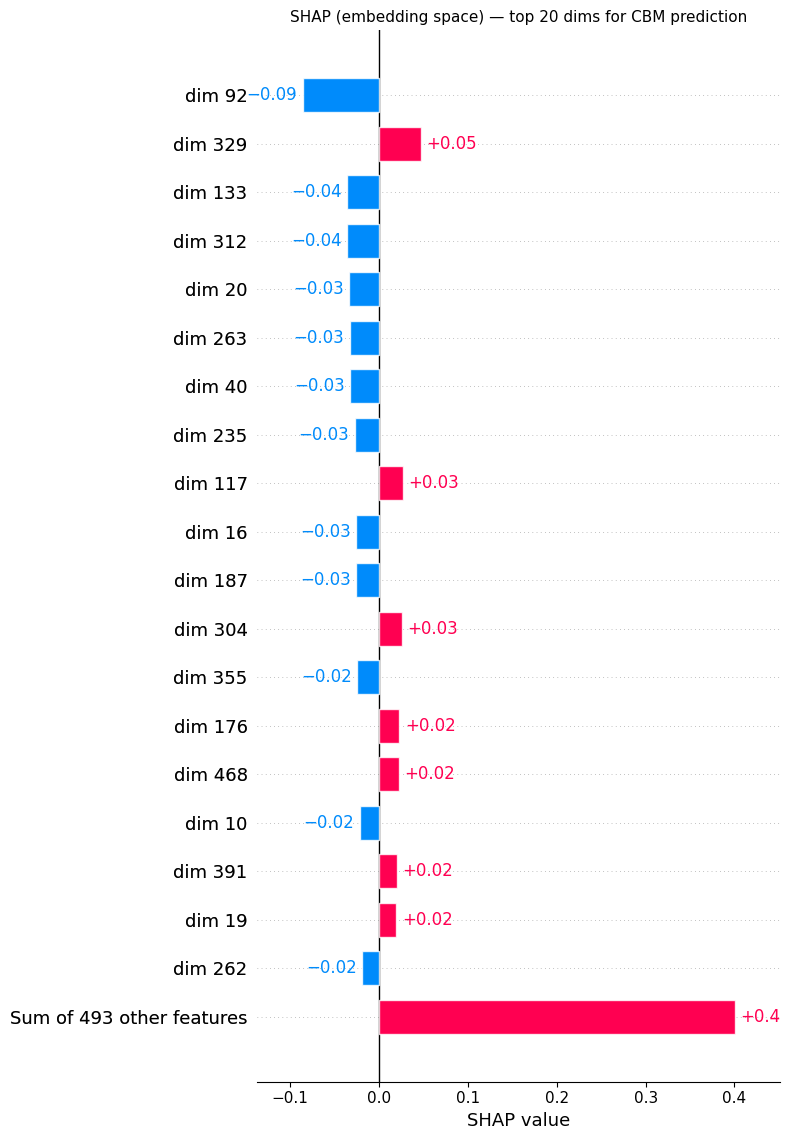

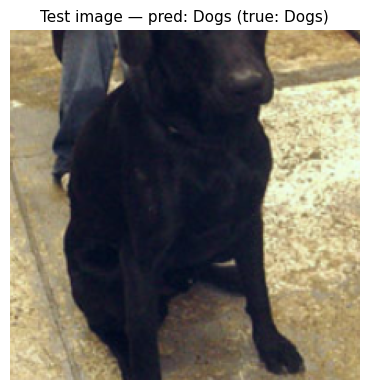

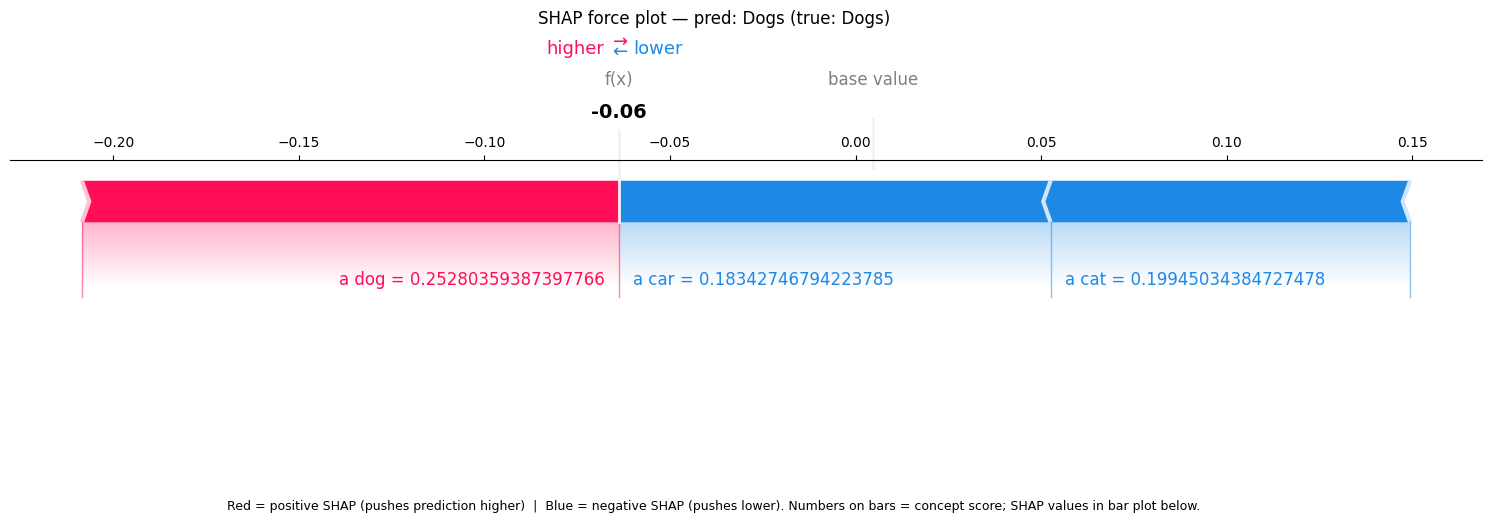

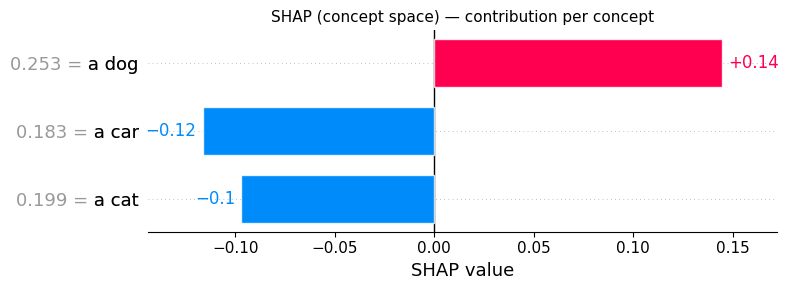

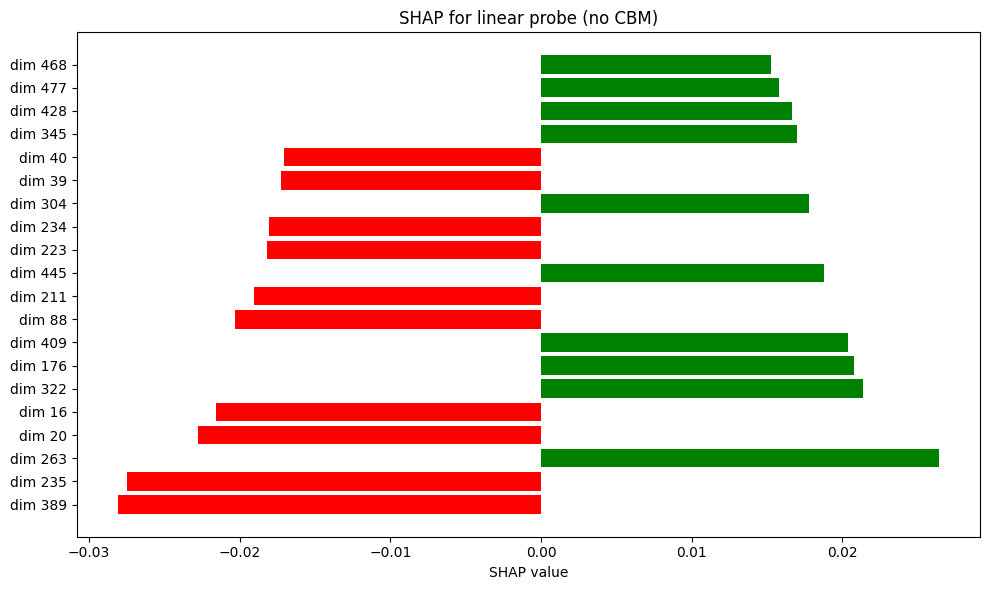

In [83]:

import shap

def _to_numpy(x):
    if hasattr(x, "cpu"):
        return x.detach().cpu().numpy()
    return np.asarray(x)

# SHAP with CBM: wrapper so gradients flow for GradientExplainer.
cbm_for_shap = model_cbm_class if 'model_cbm_class' in dir() else model_unbiaised

class CBMWrapperForSHAP(nn.Module):
    """Same as CBM but without detach on concept_scores so SHAP can backprop to embedding."""
    def __init__(self, cbm):
        super().__init__()
        self.cbm = cbm
    def forward(self, embed):
        embed_n = F.normalize(embed.float(), dim=1)
        concept_n = F.normalize(self.cbm.concept_features, dim=1)
        concept_scores = embed_n @ concept_n.T
        return self.cbm.linear(concept_scores)

# Background embeddings and one test sample from dataloader_embed_test.
background_embeds = []
test_embed, test_label = None, None
for batch in dataloader_embed_test:
    background_embeds.append(batch["input"])
    if test_embed is None:
        test_embed = batch["input"][:1].to(device)
        test_label = batch["label"][0].item()
    if len(background_embeds) * batch["input"].shape[0] >= 50:
        break
background_embeds = torch.cat(background_embeds, dim=0)[:50].to(device)

wrapper = CBMWrapperForSHAP(cbm_for_shap).to(device)
explainer_shap = shap.GradientExplainer(wrapper, background_embeds)
shap_values = explainer_shap.shap_values(test_embed)

# Predicted class and embedding-space SHAP values.
with torch.no_grad():
    pred_class = cbm_for_shap(test_embed).argmax(dim=1).item()
sv_raw = _to_numpy(shap_values)
if isinstance(shap_values, list):
    sv = _to_numpy(shap_values[pred_class][0]).flatten()
elif hasattr(sv_raw, 'shape') and len(sv_raw.shape) == 3:
    # Multi-output API: shape (n_samples, n_features, n_outputs) = (1, 512, 3) → take predicted class only.
    sv = sv_raw[0, :, pred_class].flatten()
else:
    sv = sv_raw[0].flatten()
# Restrict to actual embedding size so dim labels are 0..(embed_dim-1). CLIP ViT-B/32 has 512 dims.
embed_dim = int(test_embed.shape[1]) if hasattr(test_embed, 'shape') else 512
sv = sv[:embed_dim]

# 1) Embedding-space SHAP: top 20 of embed_dim dims (dim 0 to embed_dim-1). "Sum of X other" = embed_dim - 20.
exp_embed = shap.Explanation(values=sv.reshape(1, -1), feature_names=[f"dim {i}" for i in range(len(sv))])
shap.plots.bar(exp_embed[0], max_display=20, show=False)
plt.title("SHAP (embedding space) — top 20 dims for CBM prediction", fontsize=11)
plt.tight_layout()
plt.show()

# SHAP in concept space: use only 3-concept CBM when available (a cat, a dog, a car) for consistency with Q8/LIME.
cbm_concept_shap = None
if 'model_cbm_class' in dir() and getattr(model_cbm_class.linear, 'in_features', -1) == 3:
    cbm_concept_shap = model_cbm_class
if cbm_concept_shap is None and getattr(cbm_for_shap.linear, 'in_features', -1) == 3:
    cbm_concept_shap = cbm_for_shap
if cbm_concept_shap is None:
    cbm_concept_shap = cbm_for_shap
n_concepts_model = cbm_concept_shap.linear.in_features
if n_concepts_model == 3 and 'List_concepts_class' in dir():
    concept_names_full = list(List_concepts_class)
elif n_concepts_model == 5 and 'List_concepts' in dir():
    concept_names_full = list(List_concepts)
else:
    concept_names_full = list(cbm_concepts) if 'cbm_concepts' in dir() else []
concept_names_full = concept_names_full[:n_concepts_model]
while len(concept_names_full) < n_concepts_model:
    concept_names_full.append(f"concept_{len(concept_names_full)}")

with torch.no_grad():
    embed_n = F.normalize(test_embed.float(), dim=1)
    concept_n = F.normalize(cbm_concept_shap.concept_features, dim=1)
    test_concept_scores = (embed_n @ concept_n.T).cpu().numpy().flatten()
background_concept_list = []
for batch in dataloader_embed_test:
    emb = batch["input"].to(device)
    with torch.no_grad():
        en = F.normalize(emb.float(), dim=1)
        cn = F.normalize(cbm_concept_shap.concept_features, dim=1)
        background_concept_list.append((en @ cn.T).cpu().numpy())
    if len(background_concept_list) * emb.shape[0] >= 50:
        break
background_concept_scores = np.vstack(background_concept_list)[:50].astype(np.float32)

explainer_concept = shap.GradientExplainer(cbm_concept_shap.linear, torch.tensor(background_concept_scores).to(device))
test_cs_tensor = torch.tensor(test_concept_scores.astype(np.float32)).unsqueeze(0).to(device)
sv_concept = explainer_concept.shap_values(test_cs_tensor)
if isinstance(sv_concept, list):
    sv_concept_one = _to_numpy(sv_concept[pred_class][0]).flatten()
else:
    sv_concept_one = _to_numpy(sv_concept[0]).flatten()

n_actual = len(sv_concept_one)
# When we have exactly 3 named concepts (e.g. a cat, a dog, a car), show only those 3 for consistency — no "concept_3" etc.
if "List_concepts_class" in dir() and len(List_concepts_class) == 3 and n_actual > 3:
    n_display = 3
    sv_2d = np.asarray(sv_concept_one[:n_display], dtype=float).reshape(1, -1)
    test_concept_scores_one = np.asarray(test_concept_scores).flatten()[:n_display]
    concept_names_shap = list(List_concepts_class)
    n_actual = 3
else:
    n_display = n_actual
    sv_2d = np.asarray(sv_concept_one[:n_actual], dtype=float).reshape(1, -1)
    test_concept_scores_one = np.asarray(test_concept_scores).flatten()[:n_actual]
    concept_names_shap = list(concept_names_full)[:n_actual]
    while len(concept_names_shap) < n_actual:
        concept_names_shap.append(f"concept_{len(concept_names_shap)}")
test_concept_scores_one = np.asarray(test_concept_scores).flatten()[:n_actual]

base_value_concept = explainer_concept.expected_value if hasattr(explainer_concept, 'expected_value') else cbm_concept_shap.linear(torch.tensor(background_concept_scores).to(device)).mean(dim=0).detach().cpu().numpy()
base_val_scalar = float(base_value_concept[pred_class] if hasattr(base_value_concept, '__len__') else base_value_concept)

# Force plot: ensure features and feature_names have exactly the same length as shap_values (sv_2d already set above).
n = int(sv_2d.shape[1])
feat_1d = np.asarray(test_concept_scores_one, dtype=float).flatten()
feat_1d = feat_1d[:n] if len(feat_1d) >= n else np.pad(feat_1d, (0, n - len(feat_1d)), constant_values=0.0)
names = (list(concept_names_shap)[:n] if concept_names_shap else [])
while len(names) < n:
    names.append(f"concept_{len(names)}")
names = names[:n]
assert len(feat_1d) == n and len(names) == n, f"lengths: feat_1d={len(feat_1d)}, names={len(names)}, n={n}"

# Show the test image that is being explained (same index as first sample in dataloader_embed_test).
if 'dataloader_test' in dir():
    batch_img = next(iter(dataloader_test))
    img0 = batch_img["input"][0]
    img_np = img0.permute(1, 2, 0).cpu().numpy()
    if img_np.max() <= 1.0 and img_np.min() >= 0:
        pass
    else:
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Test image — pred: {idx_to_class[pred_class]} (true: {idx_to_class[test_label]})", fontsize=11)
    plt.tight_layout()
    plt.show()

# Force plot: Red = pushes prediction higher, Blue = pushes lower (same convention as bar plot below).
shap.plots.force(base_val_scalar, sv_2d, feat_1d, names, matplotlib=True, show=False, figsize=(16, 5), plot_cmap='RdBu')
fig = plt.gcf()
fig.subplots_adjust(top=0.72, bottom=0.18, left=0.06, right=0.98)
fig.suptitle(f"SHAP force plot — pred: {idx_to_class[pred_class]} (true: {idx_to_class[test_label]})", fontsize=12, y=1.02)
plt.figtext(0.5, 0.02, "Red = positive SHAP (pushes prediction higher)  |  Blue = negative SHAP (pushes lower). Numbers on bars = concept score; SHAP values in bar plot below.", ha="center", fontsize=9)
plt.show()

# 2) Concept-space SHAP bar: contribution of each concept (same SHAP values as force plot above).
exp_concept = shap.Explanation(values=sv_2d, base_values=base_val_scalar, data=feat_1d.reshape(1, -1), feature_names=names)
shap.plots.bar(exp_concept[0], show=False)
plt.title("SHAP (concept space) — contribution per concept", fontsize=11)
plt.tight_layout()
plt.show()

# SHAP without CBM: explain the linear probe (embedding -> class) in the same embedding space.
# Requires the linear probe model from earlier (e.g. 'model' after linear probing). If not in scope, skip.
if 'model' in dir() and not isinstance(model, type(cbm_for_shap)):
    try:
        explainer_linear = shap.GradientExplainer(model, background_embeds)
        shap_linear = explainer_linear.shap_values(test_embed)
        pred_linear = model(test_embed).argmax(dim=1).item()
        sl_raw = _to_numpy(shap_linear)
        if isinstance(shap_linear, list):
            sv_lin = _to_numpy(shap_linear[pred_linear][0]).flatten()
        elif hasattr(sl_raw, 'shape') and len(sl_raw.shape) == 3:
            sv_lin = sl_raw[0, :, pred_linear].flatten()
        else:
            sv_lin = sl_raw[0].flatten()
        embed_dim_lin = int(test_embed.shape[1]) if hasattr(test_embed, 'shape') else 512
        sv_lin = sv_lin[:embed_dim_lin]
        idx_top_lin = np.argsort(np.abs(sv_lin))[-20:][::-1]
        plt.figure(figsize=(10, 6))
        plt.barh(range(20), sv_lin[idx_top_lin], color=["green" if sv_lin[i] > 0 else "red" for i in idx_top_lin])
        plt.yticks(range(20), [f"dim {i}" for i in idx_top_lin])
        plt.xlabel("SHAP value")
        plt.title("SHAP for linear probe (no CBM)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("SHAP without CBM skipped:", e)



## 7 : Counterfactual (Au niveau de z)

**question11: please perform a counterfactual explanation.**

Z-score change (delta) per concept: ['-0.1000', '0.1000', '0.1000']


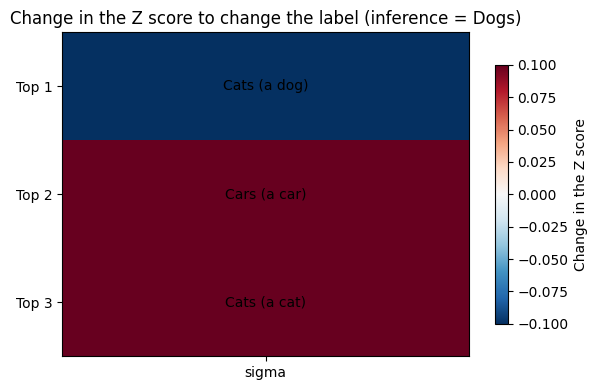

In [85]:
# For a test sample, find for each "top" concept the minimal change in Z-score that flips the prediction.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import torch
import torch.nn.functional as F

# Use CBM and concept list from earlier sections (model_cbm_class or model_unbiaised)
cbm = model_cbm_class if 'model_cbm_class' in dir() else model_unbiaised
concept_names = List_concepts_class if 'List_concepts_class' in dir() else List_concepts
class_names = List_classes if 'List_classes' in dir() else ['Dogs', 'Cats', 'Cars']
cbm.eval()

# One test sample: get embedding and concept scores z
test_embed, test_label = None, None
for batch in dataloader_embed_test:
    test_embed = batch["input"][:1].to(device)
    test_label = batch["label"][0].item()
    break
embed_n = F.normalize(test_embed.float(), dim=1)
concept_n = F.normalize(cbm.concept_features, dim=1)
z = (embed_n @ concept_n.T).detach()  # (1, n_concepts)
pred_class = cbm.linear(z).argmax(dim=1).item()
inference_name = class_names[pred_class]

# Rank concepts by influence on current prediction (absolute linear weight for predicted class)
w = cbm.linear.weight[pred_class].detach().cpu().numpy()
n_concepts = z.shape[1]
top_k = min(5, n_concepts)
idx_top = np.argsort(np.abs(w))[-top_k:][::-1]

# For each top concept, search for minimal delta in Z that flips the label
deltas = np.linspace(-10, 10, 201)
results = []  # list of (counterfactual_label_or_None, delta_or_0, concept_name)
for rank, k in enumerate(idx_top):
    best_delta, best_new_class = None, None
    for delta in deltas:
        z_trial = z.clone()
        z_trial[0, k] = z_trial[0, k].item() + delta
        with torch.no_grad():
            new_pred = cbm.linear(z_trial).argmax(dim=1).item()
        if new_pred != pred_class:
            if best_delta is None or abs(delta) < abs(best_delta):
                best_delta = delta
                best_new_class = new_pred
    if best_new_class is not None:
        results.append((class_names[best_new_class], best_delta, concept_names[k]))
    else:
        results.append(("No counterfactual", 0.0, concept_names[k]))

# Build table for plot: rows = Top 1..5, one column with text, one with delta for color
labels_for_cell = [f"{r[0]} ({r[2]})" if r[0] != "No counterfactual" else r[0] for r in results]
delta_values = np.array([r[1] for r in results])
# Matrix for heatmap: one column (sigma = delta), rows = Top 1..5
matrix = delta_values.reshape(-1, 1)
row_labels = [f"Top {i+1}" for i in range(top_k)]

# Print actual Z-score changes for report / interpretation (optional)
print("Z-score change (delta) per concept:", [f"{r[1]:.4f}" for r in results])

fig, ax = plt.subplots(figsize=(6, 4))
# Use data range for norm so small deltas show visible color (not all white)
max_abs = max(np.abs(delta_values).max(), 0.01)
norm = mcolors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
cmap = plt.cm.RdBu_r
im = ax.imshow(matrix, cmap=cmap, norm=norm, aspect='auto')
for i in range(top_k):
    ax.text(0, i, labels_for_cell[i], ha='center', va='center', fontsize=10, wrap=True)
ax.set_yticks(range(top_k))
ax.set_yticklabels(row_labels)
ax.set_xticks([0])
ax.set_xticklabels(["sigma"])
ax.set_title(f"Change in the Z score to change the label (inference = {inference_name})")
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Change in the Z score")
plt.tight_layout()
plt.show()


**Q11 — Counterfactual explanation**

We generated a counterfactual explanation in the **CBM concept space**. For one test sample, we computed its bottleneck vector *z*, where each entry is the cosine similarity between the image embedding and a concept text embedding (here: *“a cat”*, *“a dog”*, *“a car”*). The CBM prediction is then obtained by applying the linear head to *z*.  
*Note:* here *z* is a vector of **concept similarities** (not a standardized “z-score”).

To build a simple counterfactual, we changed **one concept score at a time** while keeping the other concept scores fixed. We first ranked concepts by how strongly they affect the current predicted class (using the absolute value of the linear weight for that class). Then, for each of the top concepts, we searched over a grid of delta values and kept the **smallest absolute delta** that flips the predicted label.

In the shown run, the image is predicted as **Dogs**. The heatmap summarizes the closest flips we found:
- decreasing the **“a dog”** score flips the prediction to **Cats**,
- increasing the **“a car”** score flips it to **Cars**,
- increasing the **“a cat”** score flips it to **Cats**.

The required changes are small (about 0.1 with our grid step), which suggests the decision boundary is relatively close in this concept space for this example. This kind of counterfactual is easy to interpret because it directly states **which concept score** needs to move, **in which direction**, to change the model’s decision.